# Forecast of customer churn of the telecom operator TeleDom

__Project description:__
The telecom operator TeleDom wants to combat the outflow of customers. To do this, its employees will begin to offer promotional codes and special conditions to everyone who plans to refuse communication services. To find such users in advance, TeleDom needs a model that will predict whether a subscriber will break the contract. The operator’s team collected personal data about some clients and information about their tariffs and services.

__Project goal:__
Our task is to train a model on this data to predict customer churn.

__Description of services:__
The operator provides two main types of services:
Landline telephone connection. The phone can be connected to several lines at the same time. Internet. The connection can be of two types: via a telephone line (DSL, from the English digital subscriber line—“digital  subscriber line”) or fiber optic cable (fiber optic).

__The following services are also available:__
 - Internet security: antivirus (Device Protection) and blocking of unsafe sites (Online Security);
 - Dedicated technical support line (TechSupport);
 - Cloud file storage for data backup (OnlineBackup);
 - Streaming television (StreamingTV) and movie catalog (StreamingMovies).

Clients can pay for services every month or sign a contract for 1–2 years. It is possible to pay the bill in different ways, as well as receive an electronic receipt.

__Work plan:__  
- Step 1. Download data

Download the data and perform an initial inspection.
- Step 2. Exploratory analysis and data preprocessing

Perform exploratory analysis of each dataframe and perform preprocessing if necessary. Conclude the available features: whether they will be needed for training models.
- Step 3. Data merging

Combine the features you select into one dataframe by key.
- Step 4. Exploratory analysis and preprocessing of data from the combined dataframe

Perform exploratory analysis of the merged dataframe, visualize feature distributions, and perform preprocessing if necessary. Conduct correlation analysis. We remind you that you can use not only existing features, but also generate new ones.
- Step 5. Data preparation

Prepare the data to train the model. Divide the data into two samples, taking into account the characteristics of the data and models when scaling and coding.
- Step 6: Train machine learning models

Train at least two models. For at least one of them, select at least two hyperparameters.
- Step 7. Selecting the best model

Select the best model and check its quality on a test sample.
- Step 8. General conclusion and recommendations to the customer

Make a general conclusion about the work done: describe the main stages of the work, the results obtained and give recommendations for the business.

In [1]:
#!pip install matplotlib==3.4.0 -q
#!pip install seaborn -q
#!pip install catboost -q 
#!pip install phik -q
#!pip install scikit-learn==1.0 -q

In [2]:
# Import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer,
    OrdinalEncoder)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    accuracy_score)
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import make_column_transformer
import phik
from phik.report import plot_correlation_matrix
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
# Constant
RANDOM_STATE=22072024
UPLOAD_DATE = '2020-02-01'

Let's create functions to simplify:
 - the description function displays the dataset and information about it
 - the missing_by_column function displays the number of missing values ​​in each of the features
 - the plot_distribution function plots a histogram of the distribution of values ​​and a pie chart of percentages for a given data column
 - the plot_hist_box function builds a histogram of the distribution of values ​​and a boxplot graph for a given data column.
 - detect_anomalies_iqr function detects anomalous values ​​in a column based on IQR.
 - the plot_categorical_distribution function builds a vertical bar graph showing the number of values ​​of a categorical attribute

In [3]:
def discription(df):
    df.info()
    display(df.describe())
    display(df.head())     

In [4]:
def missing_by_column(df):
    for column in df.columns:
        missing_values_count = df[column].isnull().sum()
        print(f"Column '{column}': {missing_values_count} missing")

In [5]:
def plot_distribution(data, column, pie_plot=False, top_n=None, percent=True):
    
    # Count the number of values and sort them in descending order
    sorted_counts = data[column].value_counts(ascending=False).head(top_n)
    sorted_data = pd.DataFrame({column: sorted_counts.index, 'count': sorted_counts.values})
    
    # Calculate percentages
    total_count = data[column].count()
    sorted_data['percentage'] = (sorted_data['count'] / total_count) * 100
    
    # Construct a histogram of the distribution of values
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    colors = sns.color_palette("husl", len(sorted_data))
    barplot = sns.barplot(x=sorted_data[column], y=sorted_data['count'], palette=colors)
    if top_n==None:
        plt.title(f'Value distribution: {column}')
    else:
        plt.title(f'Distribution of values: {column} (top {top_n})')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    # Add percentages above the columns
    if percent:
        for index, row in sorted_data.iterrows():
            barplot.text(index, row['count'], f'{row["percentage"]:.1f}%', color='black', ha="center")
    
    
    # Make the X axis titles vertical
    plt.xticks(rotation=90)

    # Calculate the percentage of values
    value_counts = data[column].value_counts(normalize=True).head(top_n) * 100
    labels = value_counts.index
    sizes = value_counts.values


    # Build a pie chart of the percentage
    if pie_plot:
        plt.subplot(1, 2, 2)
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
        plt.title(f'Percentage of values: {column}')
    
    plt.tight_layout()
    plt.show()

In [6]:
def plot_hist_box(data, column,bins=70):
    plt.figure(figsize=(12, 8))

    # Construct a histogram of the distribution of values
    plt.subplot(2, 1, 1)
    sns.histplot(data[column], kde=True,bins=bins)
    plt.title(f'Histogram of value distribution: {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    # Make the X axis titles vertical
    plt.xticks(rotation=90)

    # Build boxplot
    plt.subplot(2, 1, 2)
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot: {column}')
    plt.xlabel(column)
    
    plt.tight_layout()
    plt.show()

In [7]:
def detect_anomalies_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (df[column] < lower_bound) | (df[column] > upper_bound)



In [8]:
def plot_categorical_distribution(data, column, target='Quit'):
    count_data = data.groupby([column, target]).size().unstack(fill_value=0)
    proportion_data = count_data.div(count_data.sum(axis=1), axis=0)
    ax = proportion_data.plot(kind='bar', stacked=True, figsize=(10, 6))

    # Adding labels with fractions of values
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='center')

    # Adding legend and titles
    plt.legend(title=target)
    plt.title(f'Distribution of characteristic values ​​{column} by {target}')
    plt.xlabel(column)
    plt.ylabel('Proportion of values')

    plt.show()

## Loading data

Plan for this step:
- Download data
- Conduct an initial visual analysis
- Draw the first conclusions after familiarization

In [9]:
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv', index_col='customerID')
    df_personal = pd.read_csv('/datasets/personal_new.csv', index_col='customerID')
    df_internet = pd.read_csv('/datasets/internet_new.csv', index_col='customerID')
    df_phone = pd.read_csv('/datasets/phone_new.csv', index_col='customerID')
except:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv', index_col='customerID')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv', index_col='customerID')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv', index_col='customerID')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv', index_col='customerID')

In [10]:
discription(df_contract)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


- customerID — user identifier;
- BeginDate — the start date of the contract;
- EndDate—end date of the contract;
- Type — payment type: once a year or two or monthly;
- PaperlessBilling - electronic pay sheet;
- PaymentMethod — payment type;
- MonthlyCharges — monthly expenses;
- TotalCharges — total subscriber expenses.

In [11]:
discription(df_personal)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


- customerID — user identifier;
- gender - gender;
- SeniorCitizen — whether the subscriber is a pensioner;
- Partner—whether the subscriber has a spouse;
- Dependents—whether the subscriber has children.

In [12]:
discription(df_internet)

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


- customerID — user identifier;
- InternetService — connection type;
- OnlineSecurity - blocking dangerous sites;
- OnlineBackup - cloud file storage for data backup;
- DeviceProtection - antivirus;
- TechSupport - dedicated technical support line;
- StreamingTV - streaming television;
- StreamingMovies - catalog of films.

In [13]:
discription(df_phone)

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


,MultipleLines
count,6361
unique,2
top,No
freq,3390


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


- customerID — user identifier;
- MultipleLines - connect your phone to several lines at the same time.

**Conclusion:** Data has been loaded. An initial visual analysis was carried out. At this stage, there are no gaps in the data. Tables df_contract and df_personal have dimensions (7043,7) and (7043,4), and tables df_internet and df_phone, in turn, have dimensions (5517,7) and (6361,1), respectively, which can subsequently lead to the formation of gaps. Some numeric columns have a non-numeric data type. The same is true for time data.

## Exploratory data analysis and preprocessing

Plan for this step:
- Let’s conduct an exploratory data analysis for each table, namely, look at:
  - Data distribution
  - Presence of duplicates
  - Data type matching
  - Presence of outliers and anomalous values
- Let’s draw conclusions for each table

### df_contract

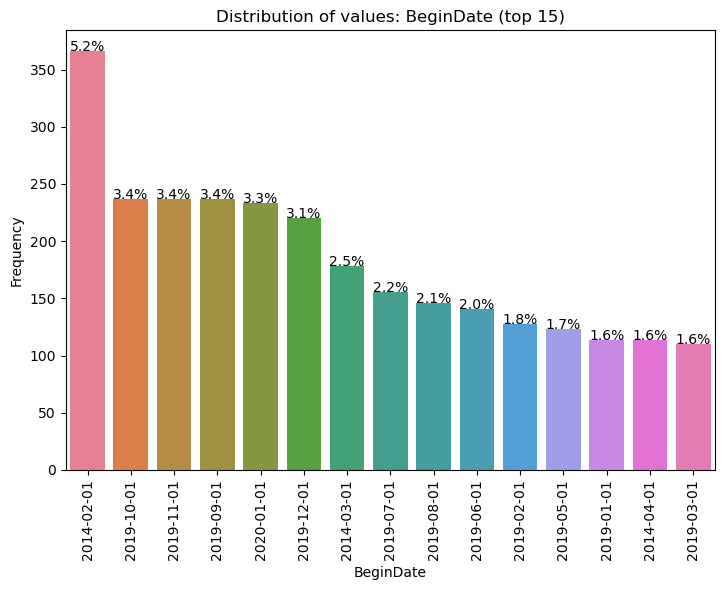

In [14]:
plot_distribution(df_contract,'BeginDate',top_n=15)

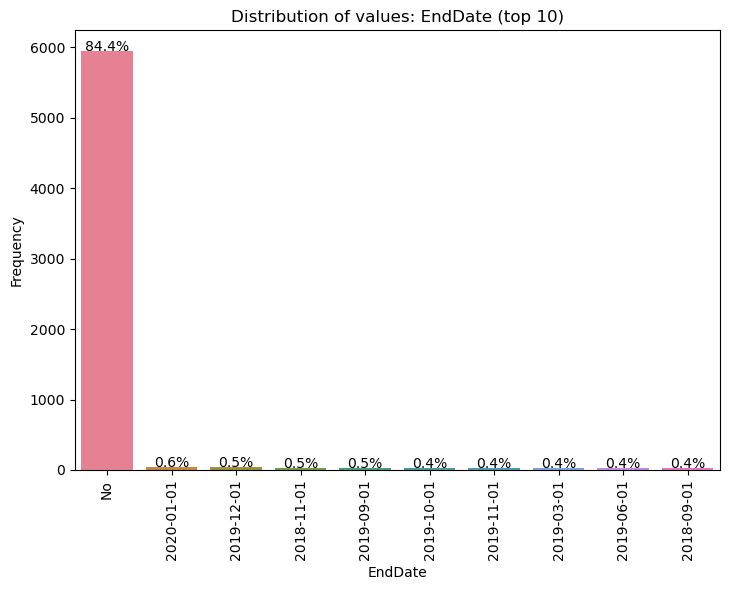

In [15]:
plot_distribution(df_contract,'EndDate',top_n=10)

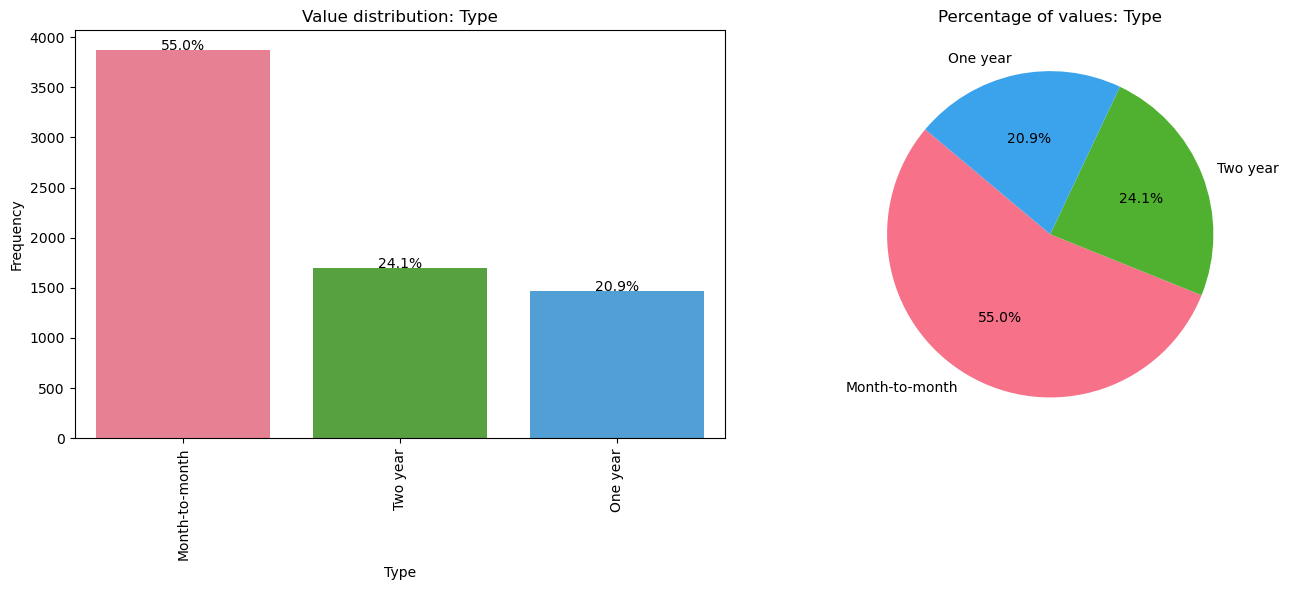

In [16]:
plot_distribution(df_contract,'Type',pie_plot=True)

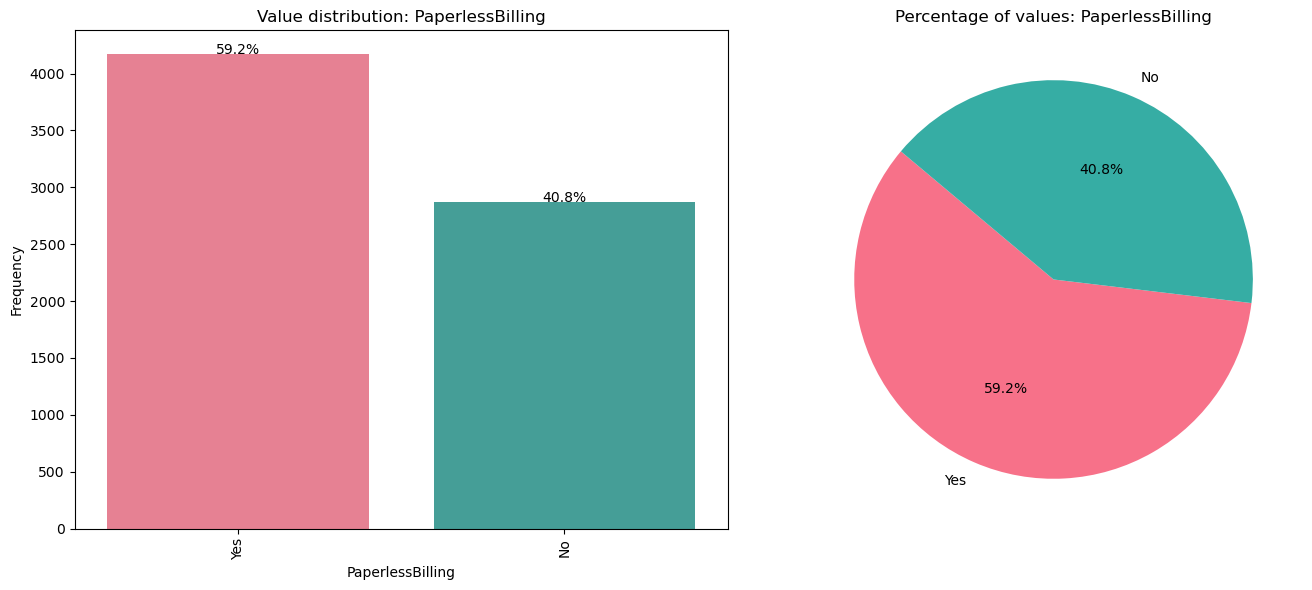

In [17]:
plot_distribution(df_contract,'PaperlessBilling',pie_plot=True)

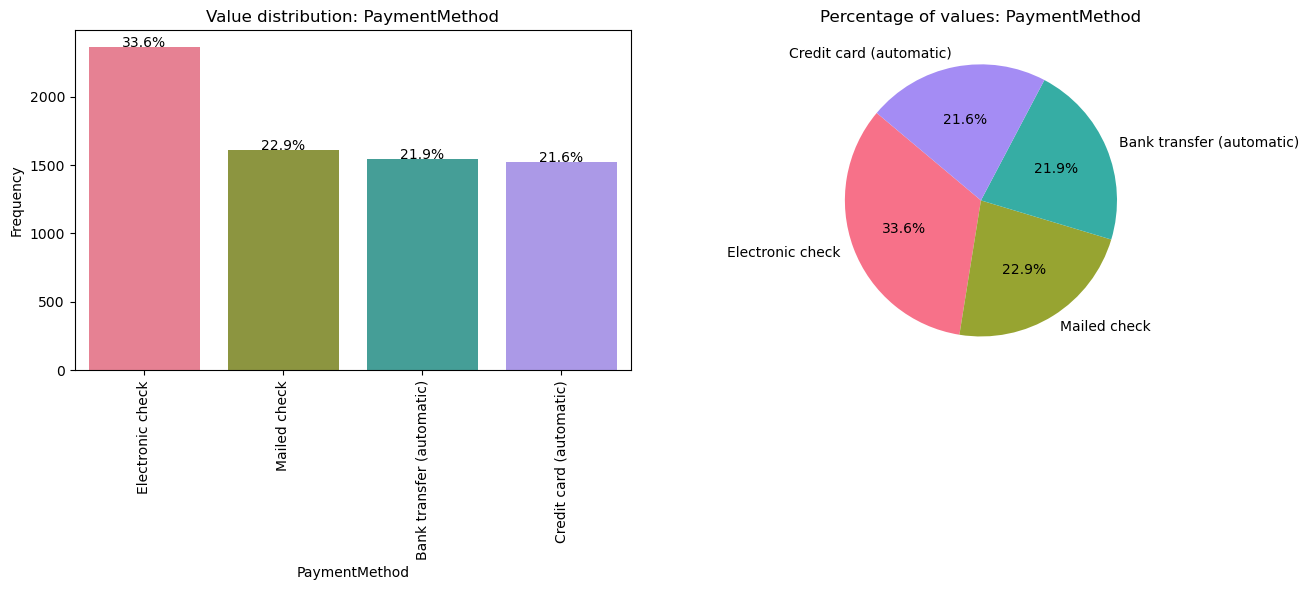

In [18]:
plot_distribution(df_contract,'PaymentMethod',pie_plot=True)

- Dates are provided monthly
- The earliest contract is from 2013-10-01
- About 84.4% have a valid contract
- Earliest terminated contract dated 2014-06-01
- 55% of clients pay for services monthly
- About 60% of clients receive invoices electronically
- The most popular payment method is via electronic check (33.6%)

Let's analyze the numerical columns

In [19]:
df_contract[df_contract['TotalCharges']==' ']

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


There are 11 gaps in the field with total expenses, but all of them are for clients who connected in the month of data upload. We will then replace such values ​​with the MonthlyCharges value and change the data type.

In [20]:
df_contract['TotalCharges'] = df_contract.apply(lambda row: row['MonthlyCharges'] if row['TotalCharges'] == ' ' else row['TotalCharges'], axis=1).astype('float')

In [21]:
df_contract[(df_contract['MonthlyCharges']==df_contract['TotalCharges']) & (df_contract['BeginDate']=='2020-02-01')]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,20.00
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,19.70


In [22]:
display(df_contract[['MonthlyCharges', 'TotalCharges']].describe())

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.377573
std,30.090047,2112.678861
min,18.250000,19.050000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


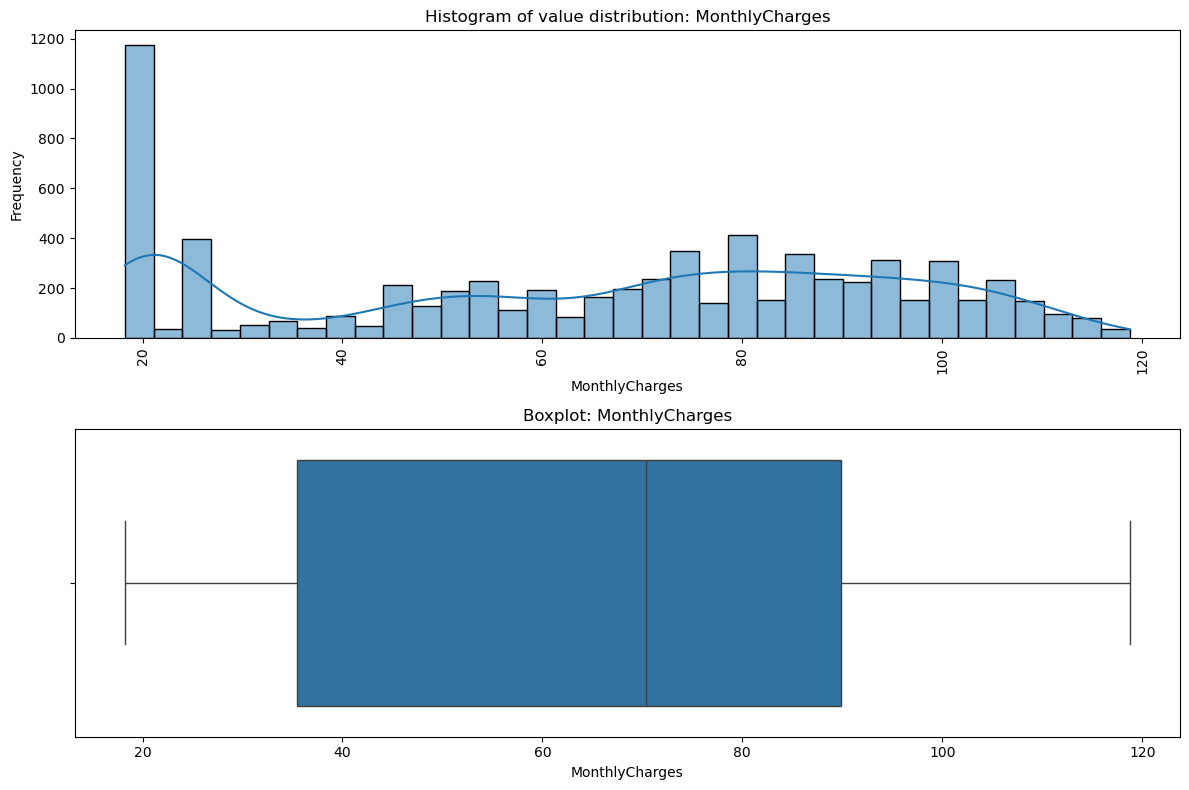

In [23]:
plot_hist_box(df_contract,'MonthlyCharges',bins=35)

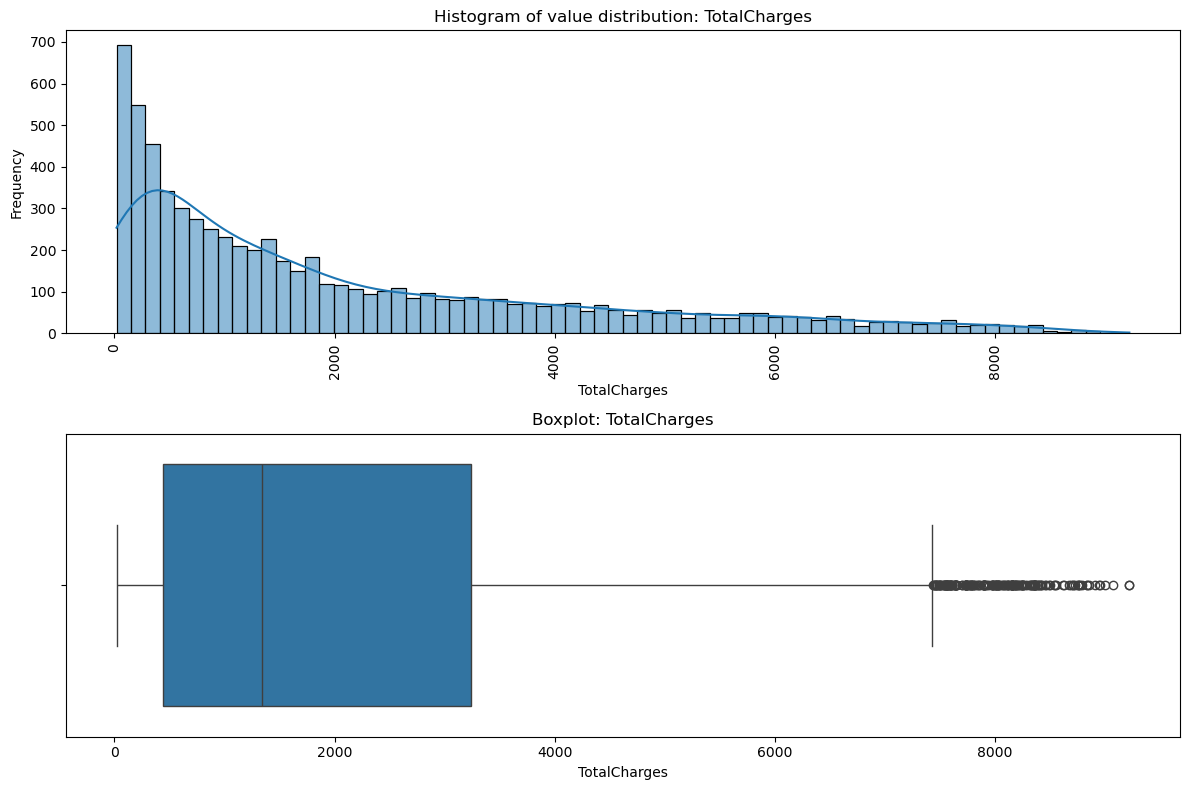

In [24]:
plot_hist_box(df_contract,'TotalCharges')

In [25]:
display(df_contract[detect_anomalies_iqr(df_contract,'TotalCharges')])
df_contract[detect_anomalies_iqr(df_contract,'TotalCharges')]['BeginDate'].value_counts()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
9959-WOFKT,2014-03-01,No,Two year,No,Bank transfer (automatic),106.70,8257.51
5067-XJQFU,2014-08-01,No,One year,Yes,Electronic check,108.45,7730.32
5954-BDFSG,2014-02-01,No,Two year,Yes,Credit card (automatic),107.50,7740.00
6728-DKUCO,2014-02-01,No,One year,Yes,Electronic check,104.15,7498.80
7255-SSFBC,2014-02-01,No,Two year,Yes,Bank transfer (automatic),112.25,8324.46
...,...,...,...,...,...,...,...
3508-CFVZL,2014-03-01,No,Two year,No,Mailed check,111.30,7902.30
0530-IJVDB,2014-04-01,No,Two year,Yes,Electronic check,114.60,8182.44
8213-TAZPM,2014-05-01,No,One year,Yes,Bank transfer (automatic),108.75,7728.86


BeginDate
2014-02-01    105
2014-03-01     28
2014-04-01     14
2014-05-01     11
2014-06-01     10
2014-08-01      9
2014-07-01      5
2014-10-01      3
2013-11-01      2
2014-12-01      2
2014-09-01      2
2013-10-01      2
2014-11-01      1
2015-02-01      1
Name: count, dtype: int64

In [26]:
discription(df_contract)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(5)
memory usage: 698.2+ KB


,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.377573
std,30.090047,2112.678861
min,18.250000,19.050000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50


In [27]:
display(df_contract[df_contract.duplicated()])
df_contract[df_contract.duplicated()].index.unique().value_counts()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7617-EYGLW,2020-01-01,No,Month-to-month,No,Electronic check,19.45,19.45
0031-PVLZI,2019-09-01,No,Month-to-month,No,Mailed check,20.35,101.75
8605-ITULD,2020-01-01,No,Month-to-month,No,Mailed check,19.55,19.55
1133-KXCGE,2018-08-01,No,One year,No,Mailed check,20.10,361.80
2668-TZSPS,2020-01-01,No,Month-to-month,No,Mailed check,20.45,20.45
9617-INGJY,2020-01-01,No,Month-to-month,Yes,Mailed check,70.60,70.60
4112-LUEIZ,2019-03-01,No,Month-to-month,Yes,Electronic check,89.50,984.50
8566-YPRGL,2020-01-01,No,Month-to-month,Yes,Mailed check,19.50,19.50
9430-NKQLY,2014-02-01,No,Two year,Yes,Credit card (automatic),25.10,1807.20


customerID
7617-EYGLW    1
9048-JVYVF    1
7932-WPTDS    1
8490-BXHEO    1
1597-FZREH    1
5028-HTLJB    1
9103-CXVOK    1
8749-CLJXC    1
2621-UDNLU    1
2717-HVIZY    1
2081-KJSQF    1
7601-WFVZV    1
3439-GVUSX    1
5666-CYCYZ    1
3590-TCXTB    1
6230-BSUXY    1
9700-ZCLOT    1
9441-QHEVC    1
8774-GSBUN    1
0031-PVLZI    1
0902-XKXPN    1
8605-ITULD    1
1133-KXCGE    1
2668-TZSPS    1
9617-INGJY    1
4112-LUEIZ    1
8566-YPRGL    1
9430-NKQLY    1
7665-TOALD    1
2990-IAJSV    1
6124-ACRHJ    1
3373-YZZYM    1
0137-UDEUO    1
1455-UGQVH    1
1319-YLZJG    1
3892-NXAZG    1
2843-CQMEG    1
Name: count, dtype: int64

- The maximum total customer spending is close to 0.
- There is bimodality and discreteness in the distribution of monthly payment values
  - The first maximum occurs at the minimum value of the monthly subscription fee
  - The second maximum is closer to the median value
  - Discretion is probably due to price rounding
- Outliers in are due to the fact that these are expenses of customers who have been using the company’s services for a long time and have a fairly large monthly payment. Perhaps we will further add categories of clients and classify them as VIP clients.
- There are no duplicates, all customerID values ​​for the displayed duplicates are unique.

### df_personal

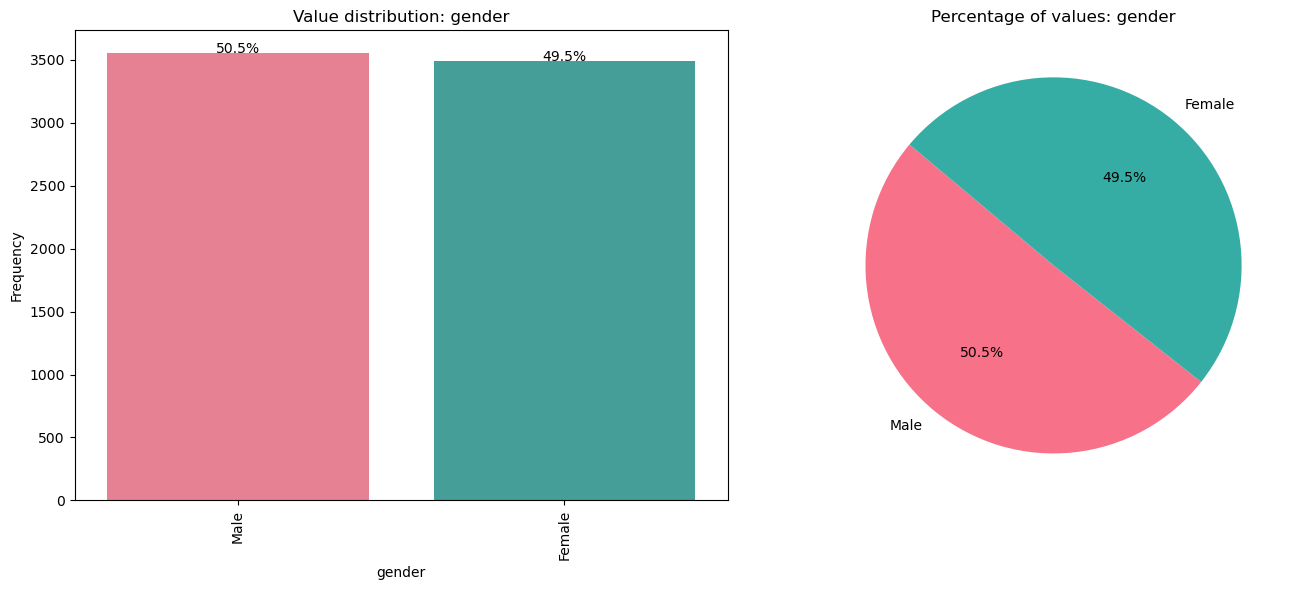

In [28]:
plot_distribution(df_personal,'gender',pie_plot=True)

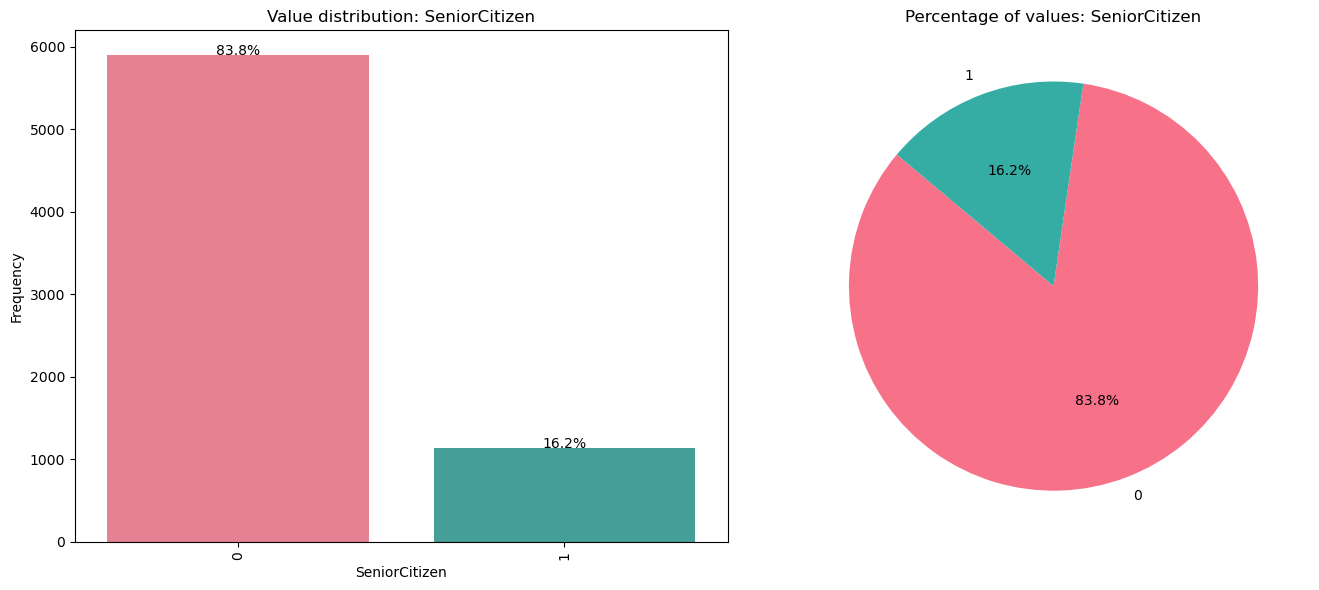

In [29]:
plot_distribution(df_personal,'SeniorCitizen',pie_plot=True)

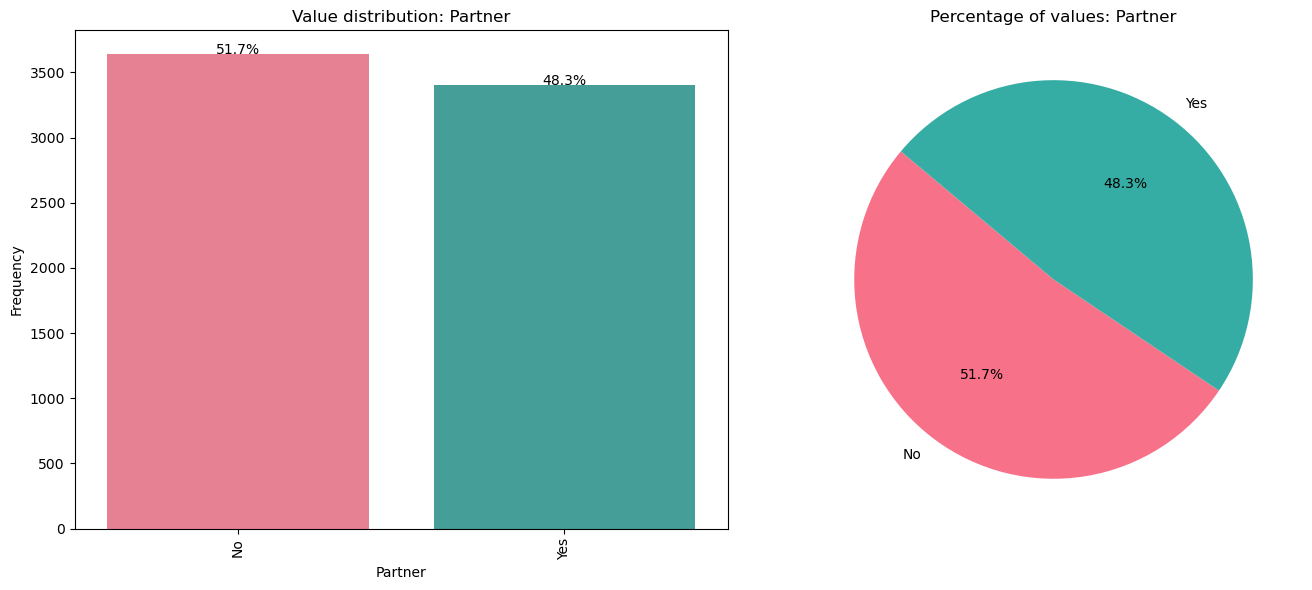

In [30]:
plot_distribution(df_personal,'Partner',pie_plot=True)

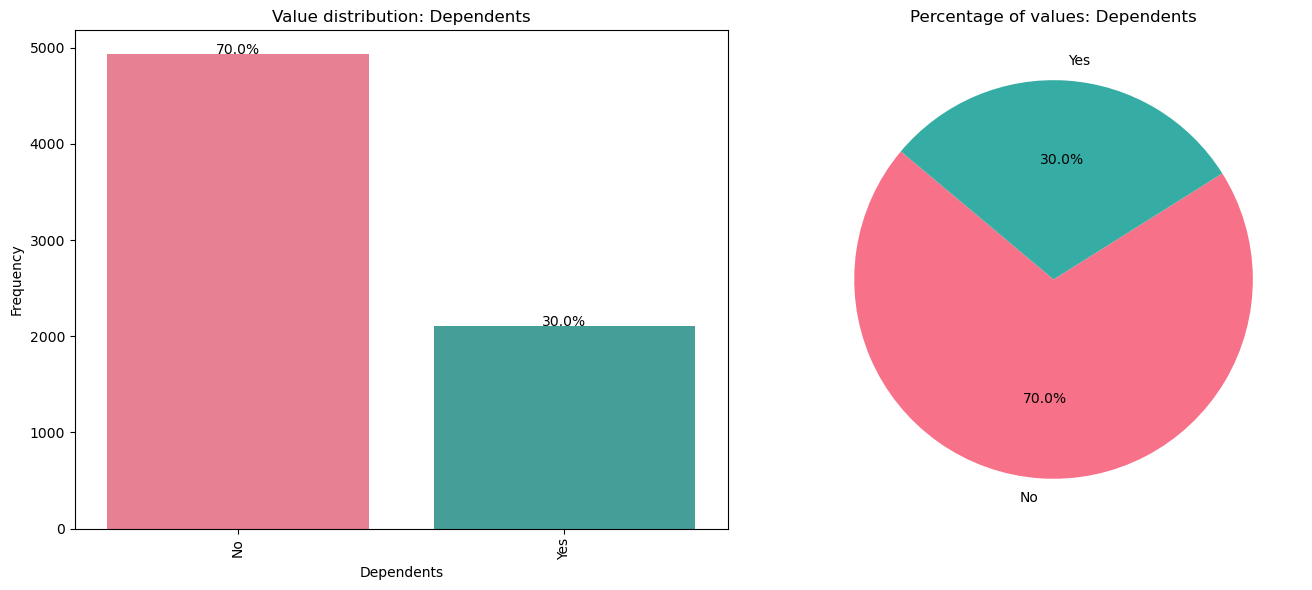

In [31]:
plot_distribution(df_personal,'Dependents',pie_plot=True)

All columns are binary.
- The gender of clients is distributed almost evenly, so this attribute will probably not be significant for the performance of the model.
- The proportion of clients of retirement age is insignificant.
- The number of married and unmarried clients is approximately the same.
- The number of clients without dependents significantly exceeds the number of clients with dependents.

### df_internet

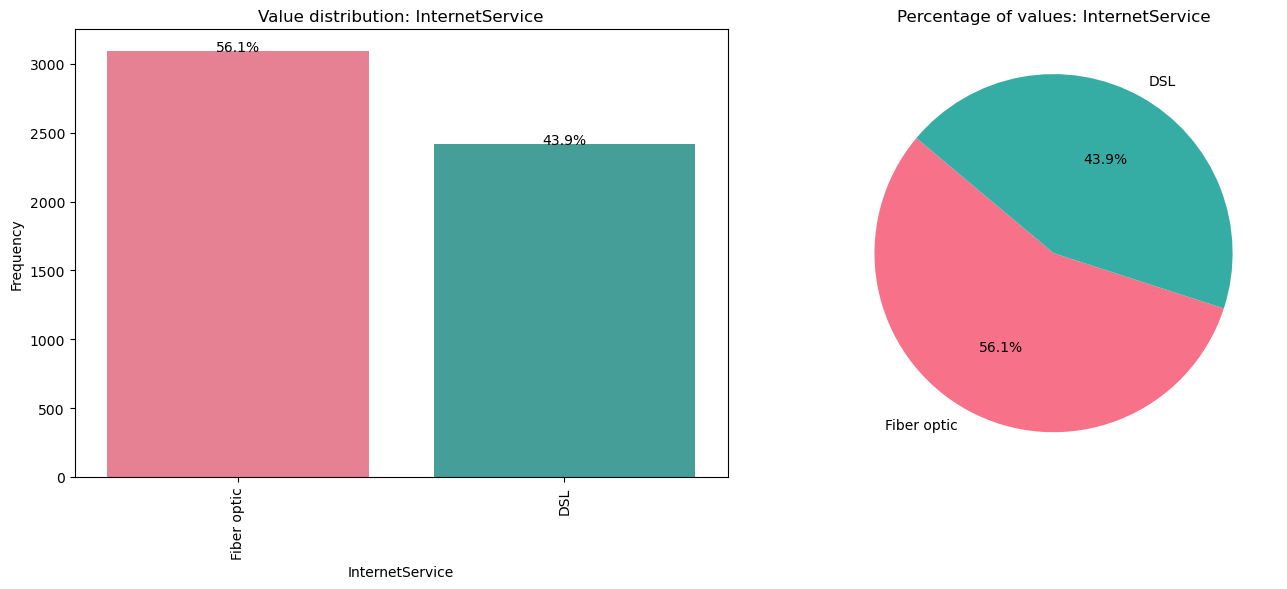

In [32]:
plot_distribution(df_internet,'InternetService',pie_plot=True)

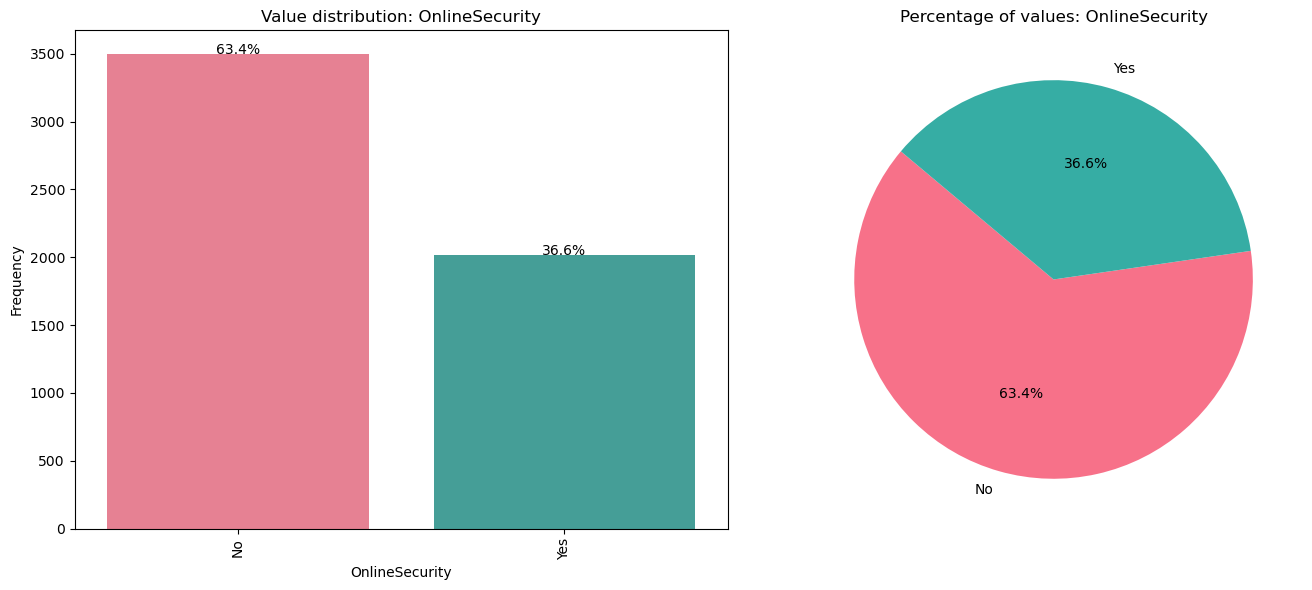

In [33]:
plot_distribution(df_internet,'OnlineSecurity',pie_plot=True)

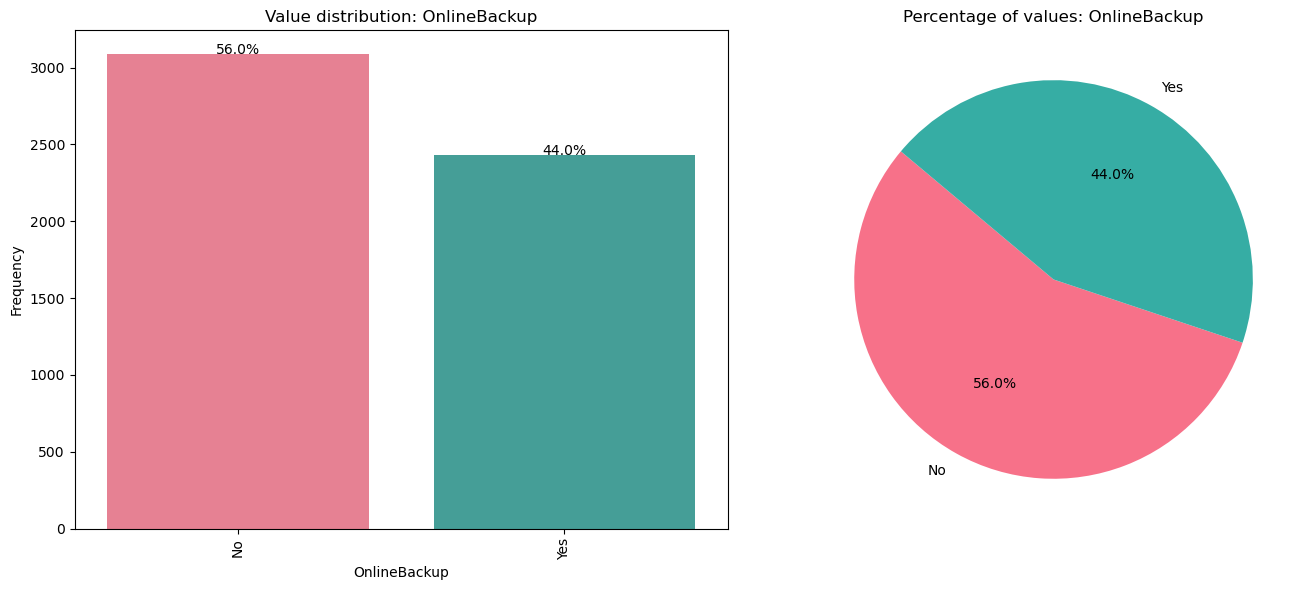

In [34]:
plot_distribution(df_internet,'OnlineBackup',pie_plot=True)

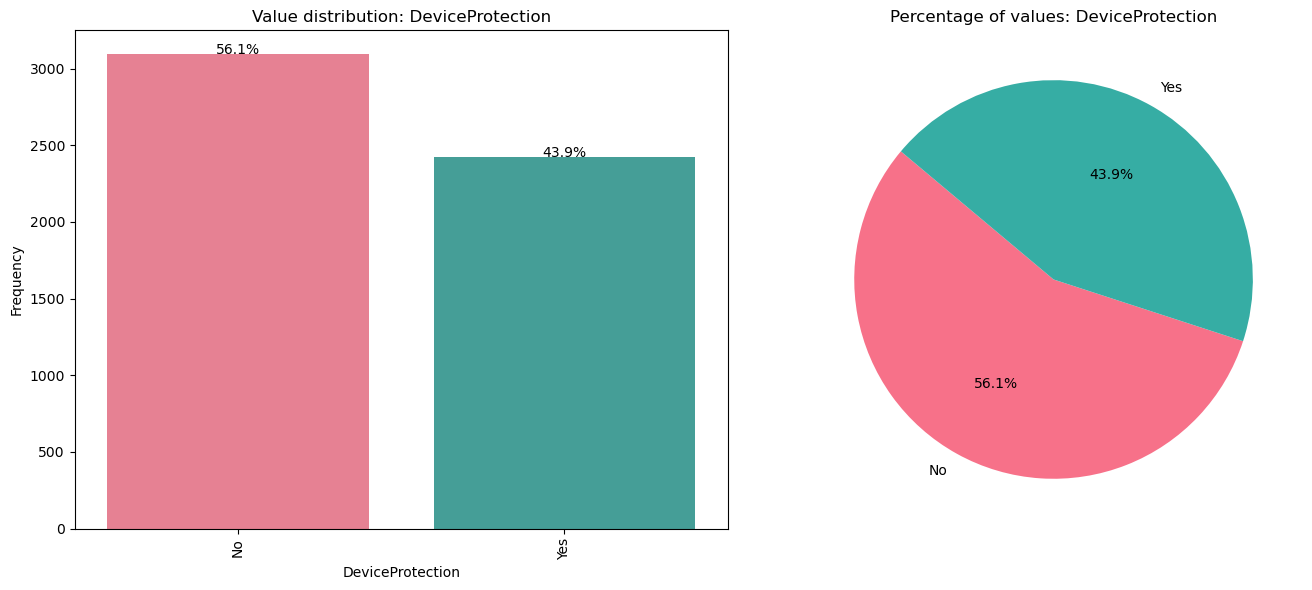

In [35]:
plot_distribution(df_internet,'DeviceProtection',pie_plot=True)

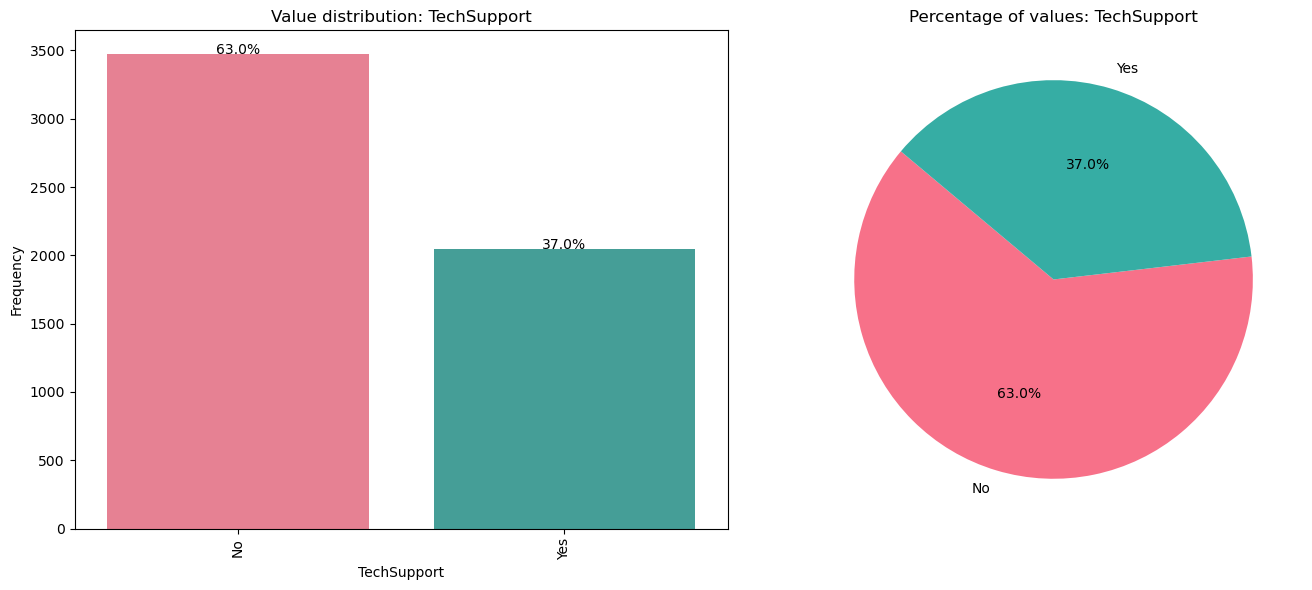

In [36]:
plot_distribution(df_internet,'TechSupport',pie_plot=True)

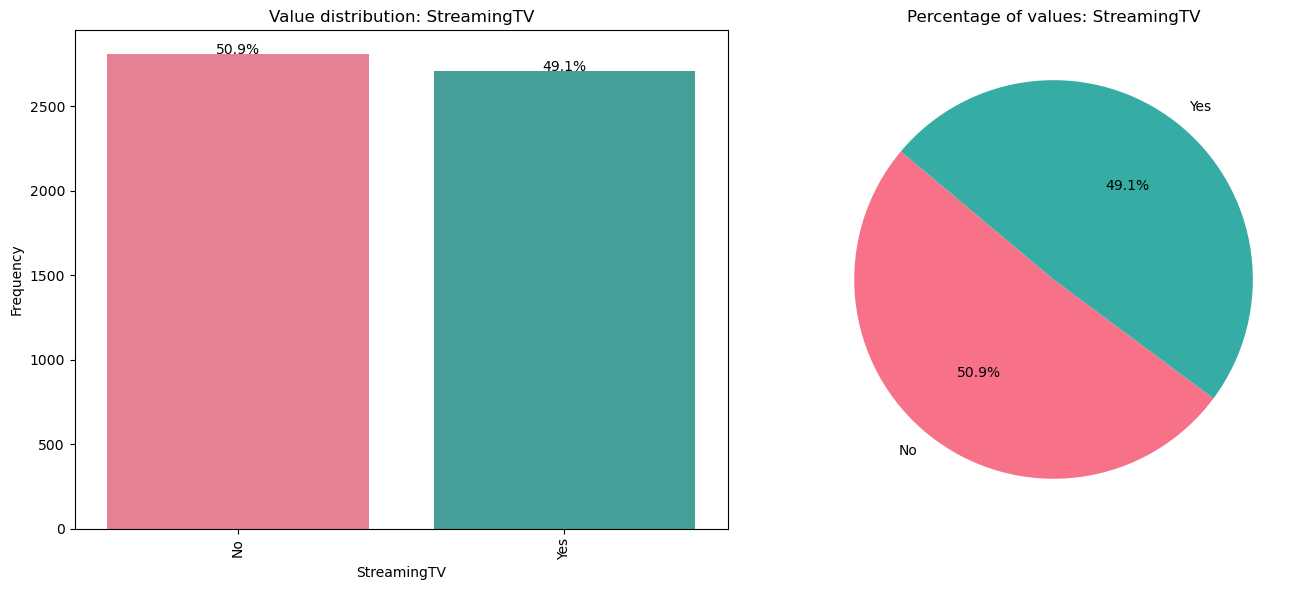

In [37]:
plot_distribution(df_internet,'StreamingTV',pie_plot=True)

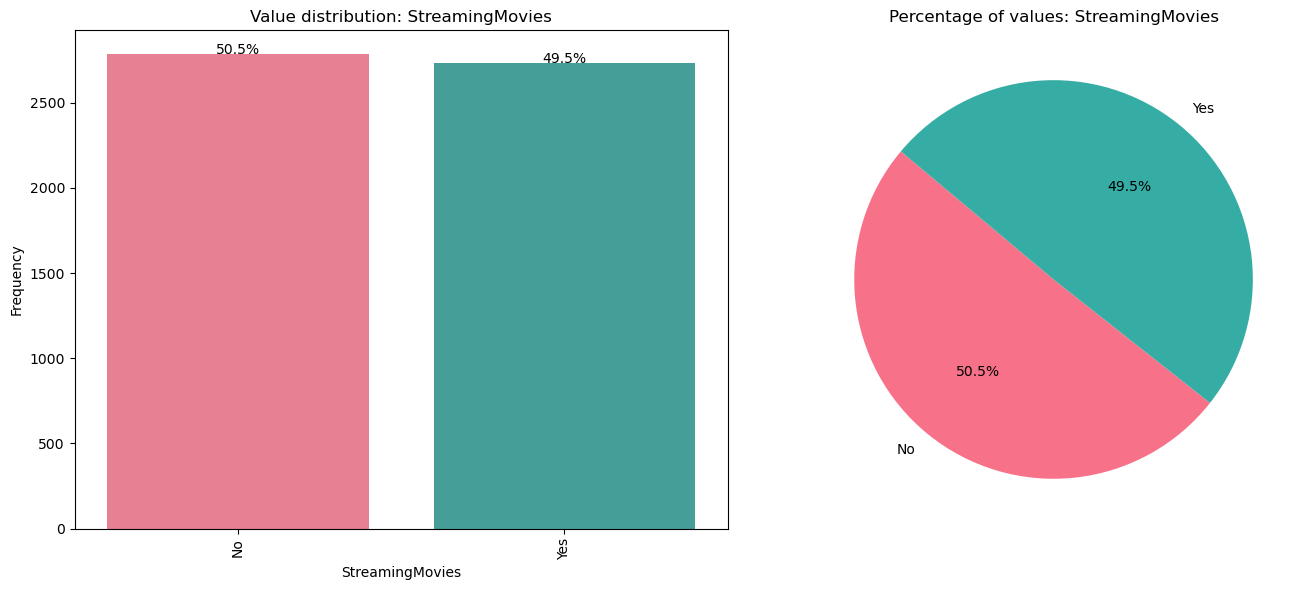

In [38]:
plot_distribution(df_internet,'StreamingMovies',pie_plot=True)

Let's count the number of services and create a summary table by connection type.

In [39]:
tmp_df=df_internet.copy()
tmp_df.set_index('InternetService')
column_sum=['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for column in tmp_df.columns:
    tmp_df[column] = tmp_df[column].replace({'Yes': 1, 'No': 0})
tmp_df['TotalQuantity']=tmp_df[column_sum].sum(axis=1)
pivot_table = pd.pivot_table(tmp_df, index='InternetService', aggfunc='sum')
display(pivot_table)

,DeviceProtection,OnlineBackup,OnlineSecurity,StreamingMovies,StreamingTV,TechSupport,TotalQuantity
InternetService,,,,,,,
DSL,1065,1086,1180,981,957,1178,6447
Fiber optic,1357,1343,839,1751,1750,866,7906


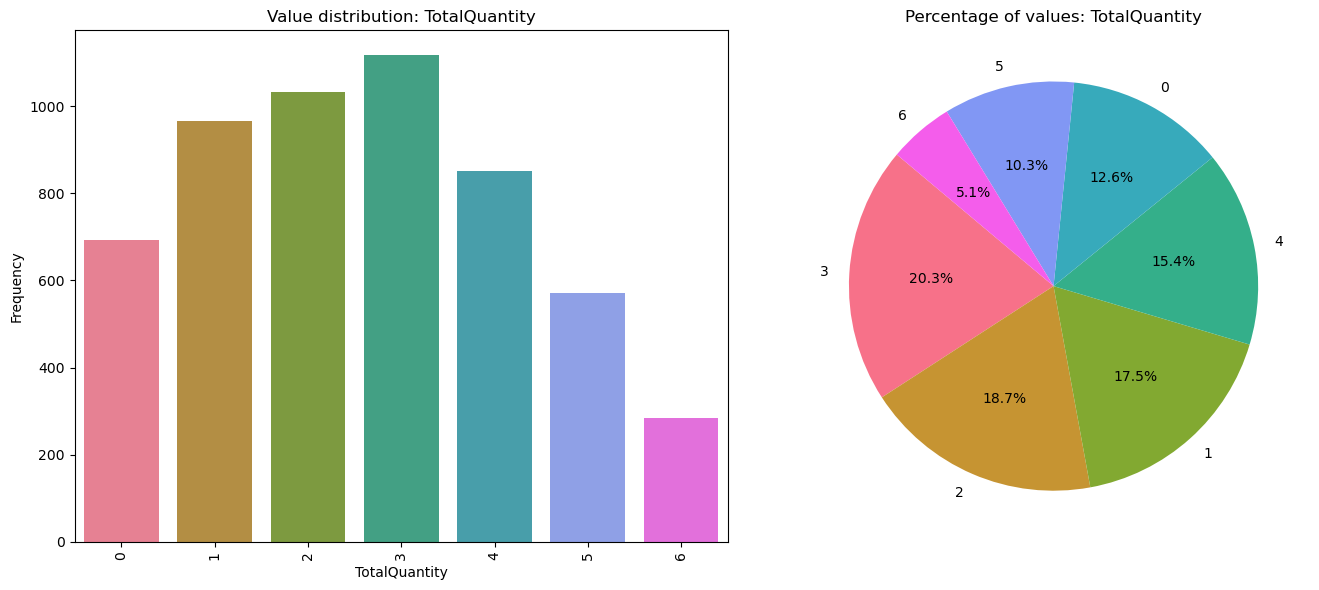

In [40]:
plot_distribution(tmp_df,'TotalQuantity',pie_plot=True,percent=False)

All columns are binary.

- It might make sense to add a column with the number of connected services.
- Most clients using the Internet are connected via fiber optic cable.
- You can see what proportion of clients have activated a particular service; For some services, the number of users and non-users is approximately equal. All attributes have only two possible values, so they can be converted to a logical type.
- Fiber service users are generally more likely to use video streaming services (movies and TV) compared to DSL users.
- DSL users are more likely to use online security and technical support than fiber users.
- In many other services (device protection and backup), fiber users outperform DSL users.
- 12.6% of clients do not use services at all.

### df_phone

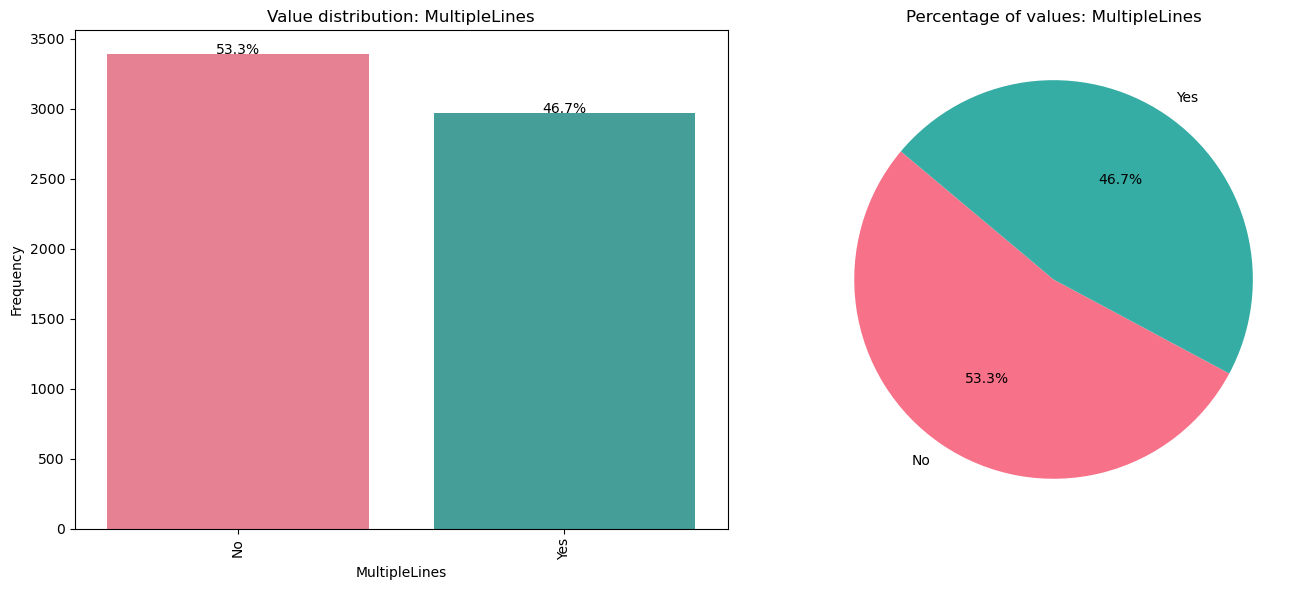

In [41]:
plot_distribution(df_phone,'MultipleLines',pie_plot=True)

The values ​​are also binary. Convert to categorical type

**Conclusion:** An exploratory analysis of each table was carried out. The gaps in the table were filled in and the data type was changed. No duplicates were found. The data is ready to be combined and further analyzed.

## Data merging

Plan for this step:
 - Merge all tables into one common one. 
 - Conduct an initial visual analysis of the combined table.
 - Draw conclusions.

In [42]:
data = df_contract.merge(df_personal, on = 'customerID', how = 'left')
data = data.merge(df_internet, on = 'customerID', how = 'left')
data = data.merge(df_phone, on = 'customerID', how = 'left')

In [43]:
discription(data)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.377573,0.162147
std,30.090047,2112.678861,0.368612
min,18.250000,19.050000,0.000000
25%,35.500000,436.750000,0.000000
50%,70.350000,1343.350000,0.000000
75%,89.850000,3236.690000,0.000000
max,118.750000,9221.380000,1.000000


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [44]:
missing_by_column(data)

Column 'BeginDate': 0 missing
Column 'EndDate': 0 missing
Column 'Type': 0 missing
Column 'PaperlessBilling': 0 missing
Column 'PaymentMethod': 0 missing
Column 'MonthlyCharges': 0 missing
Column 'TotalCharges': 0 missing
Column 'gender': 0 missing
Column 'SeniorCitizen': 0 missing
Column 'Partner': 0 missing
Column 'Dependents': 0 missing
Column 'InternetService': 1526 missing
Column 'OnlineSecurity': 1526 missing
Column 'OnlineBackup': 1526 missing
Column 'DeviceProtection': 1526 missing
Column 'TechSupport': 1526 missing
Column 'StreamingTV': 1526 missing
Column 'StreamingMovies': 1526 missing
Column 'MultipleLines': 682 missing


**Conclusion:** The data was combined into one table. After the first primary analysis, gaps are observed in the data; it is also necessary to bring all categorical characteristics to the same format.

## Exploratory analysis and preprocessing of combined dataframe data

Plan for this step:
- Carry out data preprocessing:
  - Fill in the blanks
  - Bring all data types into compliance
  - Select the target feature
  - Add new features
- Conduct exploratory analysis of the combined dataframe
- Conduct correlation analysis of the combined dataframe
- Draw conclusions

### Preprocessing of merged dataframe data

Let's add a target label *Quit* - the fact that the client has left, where 1 means the client has left, and 0 means he continues to use the services.

In [45]:
data['Quit'] = (data['EndDate'] != 'No').astype(int)

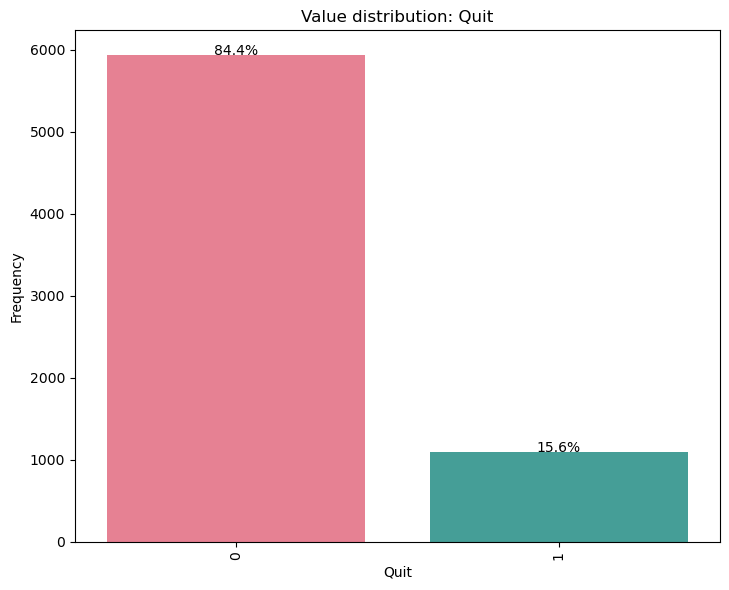

In [46]:
plot_distribution(data,'Quit')

There is a class imbalance. 84.4% of clients have a valid contract.

We will replace any gaps in binary categories with 'N/A'. Replacing gaps with 'N/A' allows us to clearly indicate that the data is missing and not equal to 0. This will also allow us to preserve the distribution of data; replacing gaps with 0 can change the distribution of data.

In [47]:
data.fillna('N/A', inplace=True)
missing_by_column(data)

Column 'BeginDate': 0 missing
Column 'EndDate': 0 missing
Column 'Type': 0 missing
Column 'PaperlessBilling': 0 missing
Column 'PaymentMethod': 0 missing
Column 'MonthlyCharges': 0 missing
Column 'TotalCharges': 0 missing
Column 'gender': 0 missing
Column 'SeniorCitizen': 0 missing
Column 'Partner': 0 missing
Column 'Dependents': 0 missing
Column 'InternetService': 0 missing
Column 'OnlineSecurity': 0 missing
Column 'OnlineBackup': 0 missing
Column 'DeviceProtection': 0 missing
Column 'TechSupport': 0 missing
Column 'StreamingTV': 0 missing
Column 'StreamingMovies': 0 missing
Column 'MultipleLines': 0 missing
Column 'Quit': 0 missing


Let's change the data type in the columns: 'BeginDate', 'EndDate', 'SeniorCitizen'
Since the information about contracts is relevant as of February 1, 2020, we will change the No value to this date and convert the column to the datetime type

In [48]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'],format= "%Y-%m-%d")

In [49]:
data.loc[data.EndDate == 'No', 'EndDate'] = UPLOAD_DATE
data['EndDate'] = pd.to_datetime(data['EndDate'] ,format= "%Y-%m-%d")

In [50]:
data['SeniorCitizen']=data['SeniorCitizen'].apply(lambda x: 'Yes' if x==1 else 'No')

Let's add new features:
 - *Duration* - duration of the contract in days
 - *TotalServices* - number of Internet services

In [51]:
data['Duration'] = (data['EndDate'] - data['BeginDate']).dt.days

In [52]:
data['TotalServices'] = data[column_sum].apply(lambda row: row.value_counts().get('Yes', 0), axis=1)

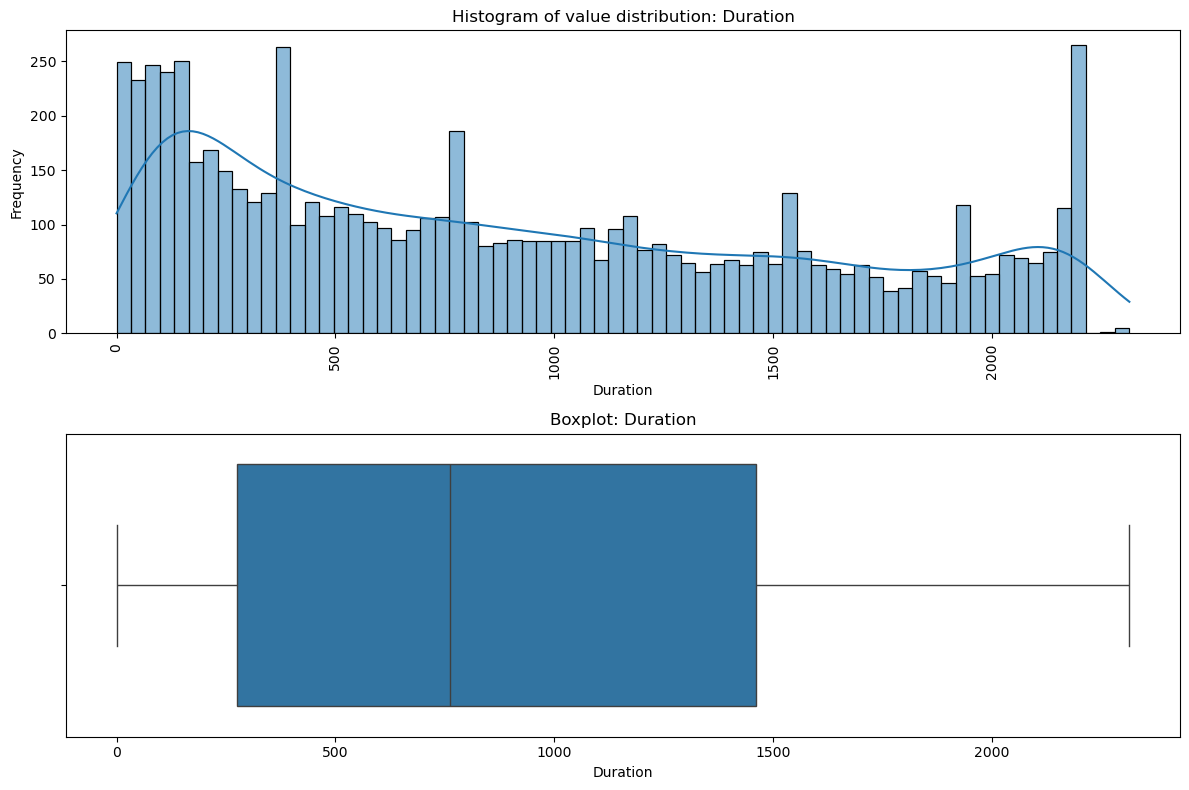

In [53]:
plot_hist_box(data,'Duration')

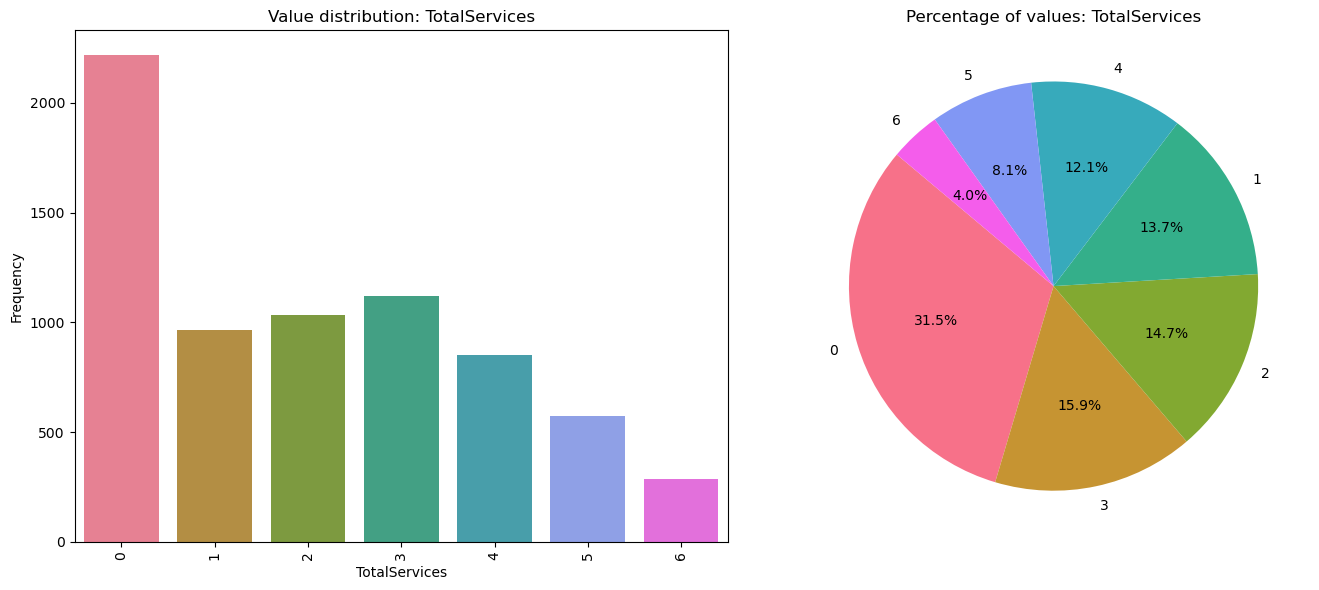

In [54]:
plot_distribution(data,'TotalServices', percent=False, pie_plot=True)

In [55]:
discription(data)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

,BeginDate,EndDate,MonthlyCharges,TotalCharges,Quit,Duration,TotalServices
count,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2019-10-16 02:22:05.912253440,64.761692,2115.377573,0.156325,898.555729,2.037910
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,19.050000,0.000000,0.000000,0.000000
25%,2015-06-01 00:00:00,2020-02-01 00:00:00,35.500000,436.750000,0.000000,276.000000,0.000000
50%,2017-09-01 00:00:00,2020-02-01 00:00:00,70.350000,1343.350000,0.000000,761.000000,2.000000
75%,2019-04-01 00:00:00,2020-02-01 00:00:00,89.850000,3236.690000,0.000000,1461.000000,3.000000
max,2020-02-01 00:00:00,2020-02-01 00:00:00,118.750000,9221.380000,1.000000,2314.000000,6.000000
std,NaN,NaN,30.090047,2112.678861,0.363189,683.130510,1.847682


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Quit,Duration,TotalServices
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,...,No,Yes,No,No,No,No,N/A,0,31,1
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,No,No,...,Yes,No,Yes,No,No,No,No,0,1036,2
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,...,Yes,Yes,No,No,No,No,No,0,123,2
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,...,Yes,No,Yes,Yes,No,No,N/A,0,1371,3
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,...,No,No,No,No,No,No,No,0,153,0


We will remove unnecessary columns after analyzing the data.

### Exploratory analysis of the merged dataframe

Let's select the features and delete the columns with dates, which we have collapsed into the *Duration* feature.

In [56]:
numerical_features = ['MonthlyCharges','TotalCharges','Duration','TotalServices']
date_features = ['BeginDate','EndDate']
data = data.drop(date_features, axis = 1)
categorical_features = [col for col in data.columns if col not in numerical_features]

In [57]:
categorical_features.remove('Quit')

Let's analyze the numerical characteristics.

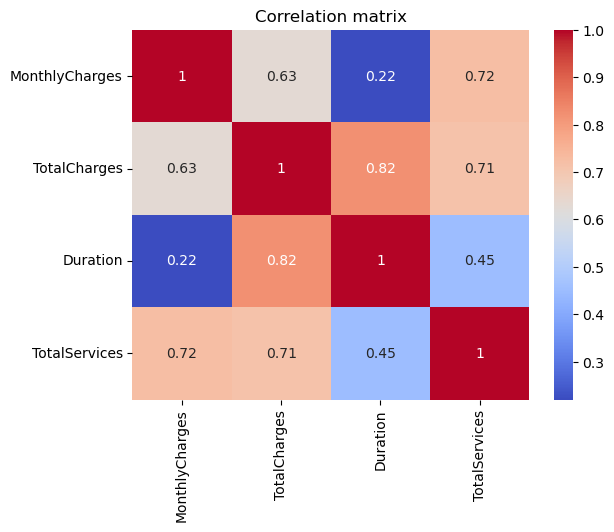

In [58]:
sns.heatmap(data[numerical_features].corr(), 
            annot=True, 
            cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

The TotalCharges column is highly correlated with Duration.
It may be worth removing this column in the future. It is not surprising that the number of services correlates with payment; it is logical that the more services, the higher the monthly fee.

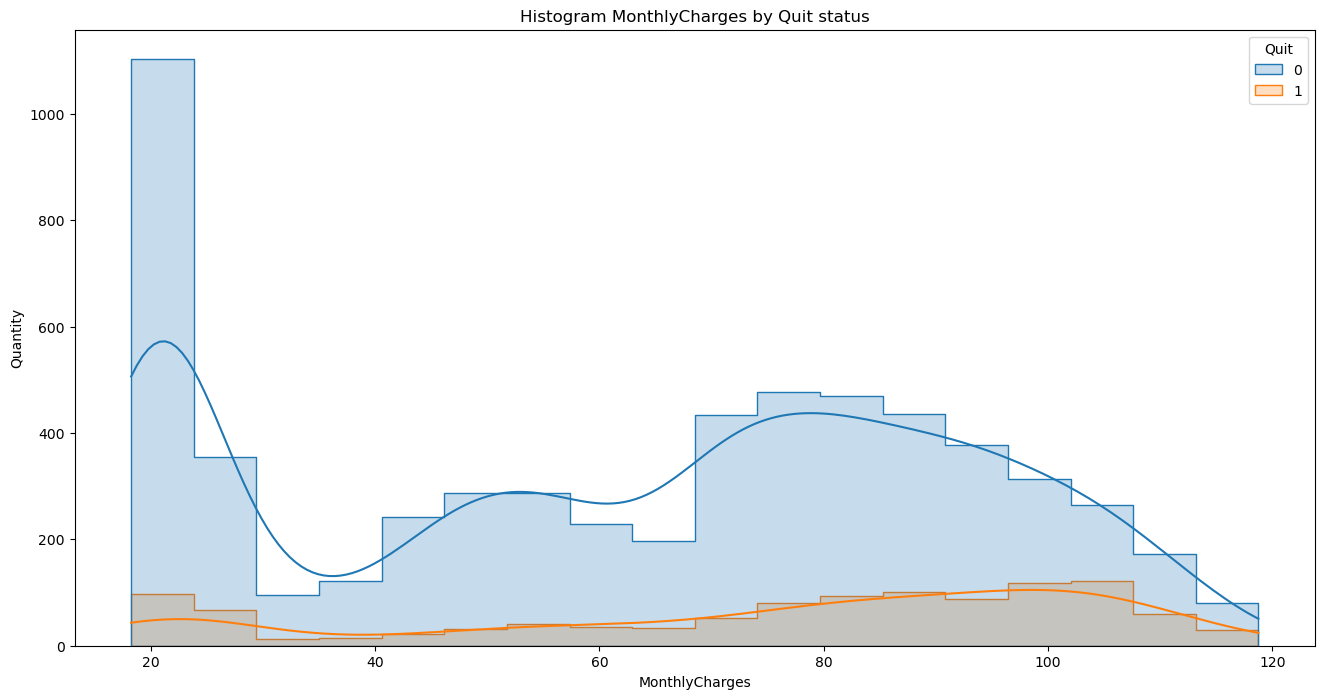

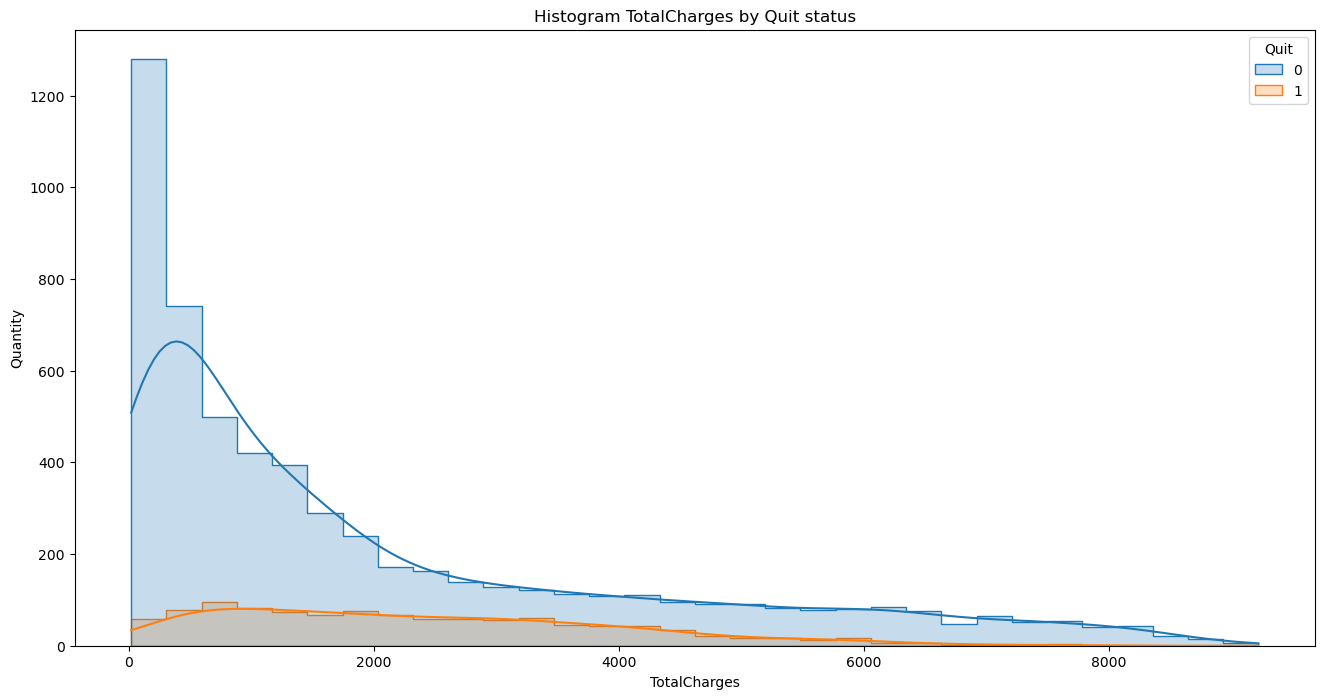

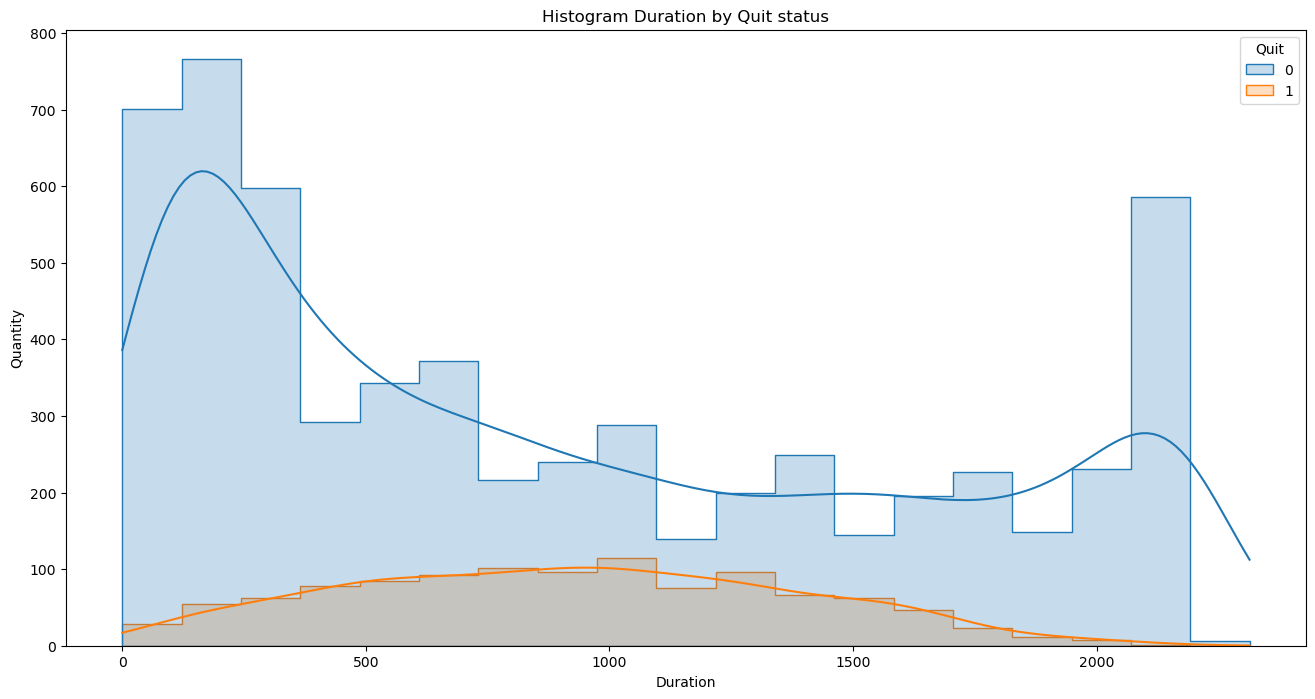

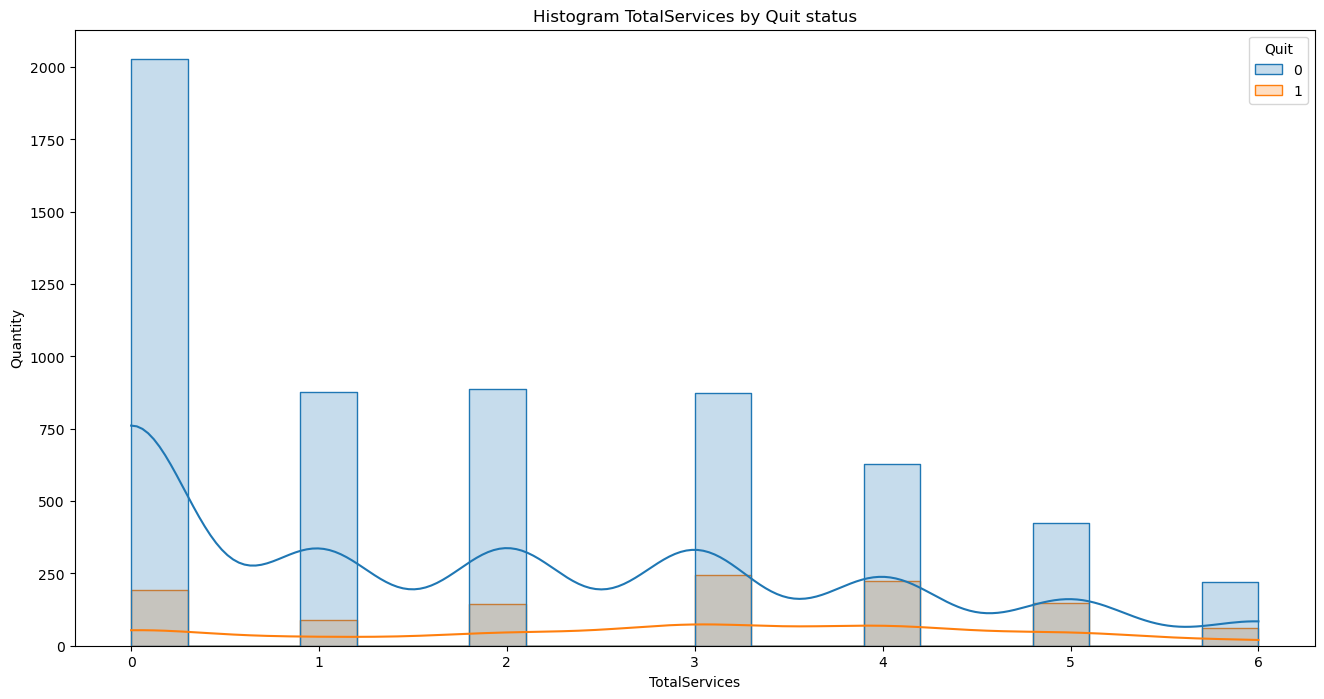

In [59]:
for feature in numerical_features:
    plt.figure(figsize=(16, 8))
    sns.histplot(data=data, x=feature, hue='Quit', kde=True, element='step')
    plt.title(f'Histogram {feature} by Quit status')
    plt.xlabel(feature)
    plt.ylabel('Quantity')
    plt.show()

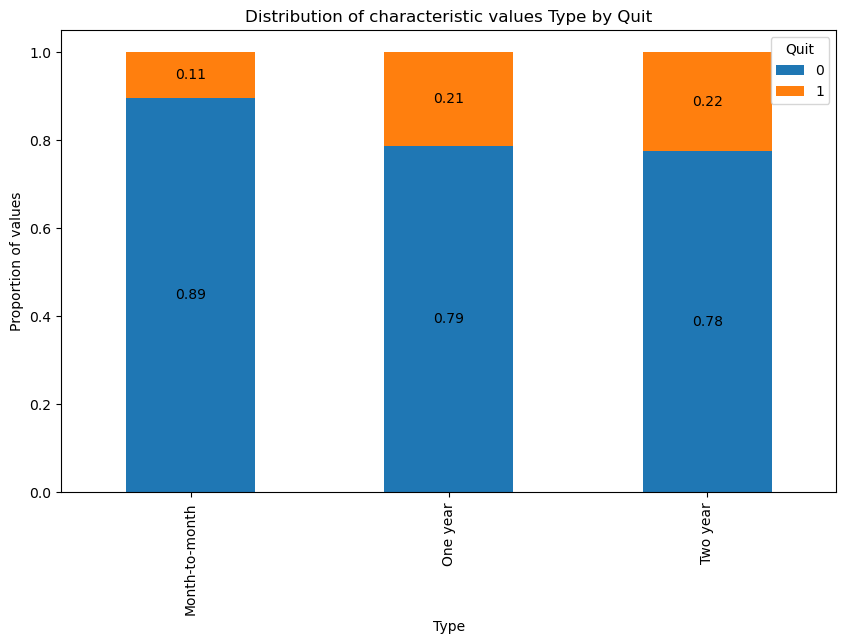

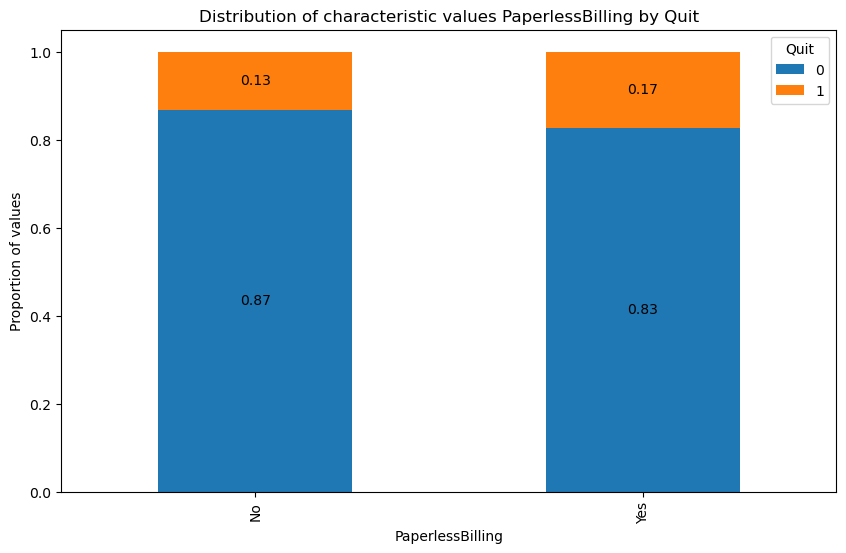

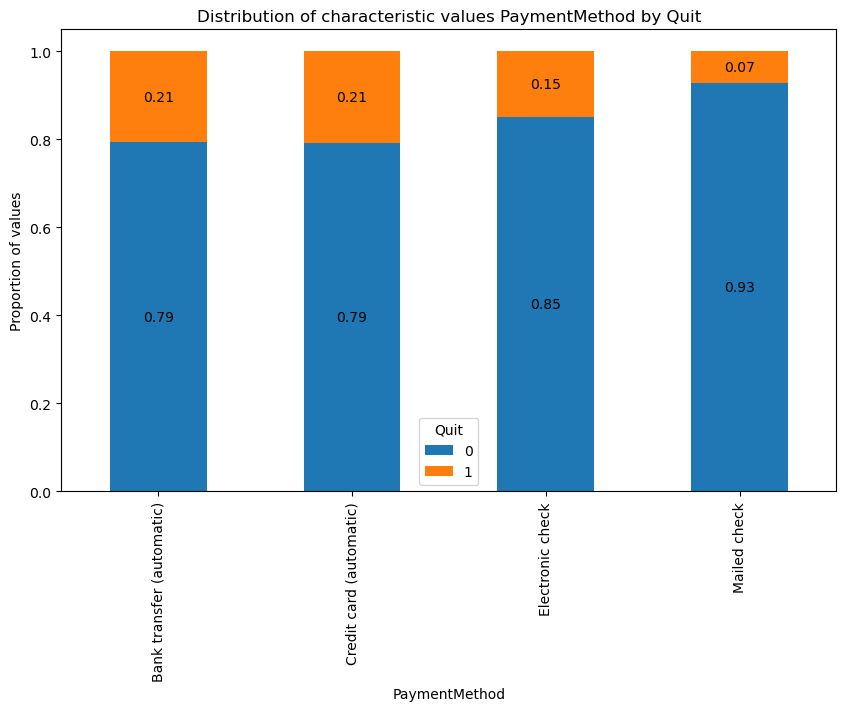

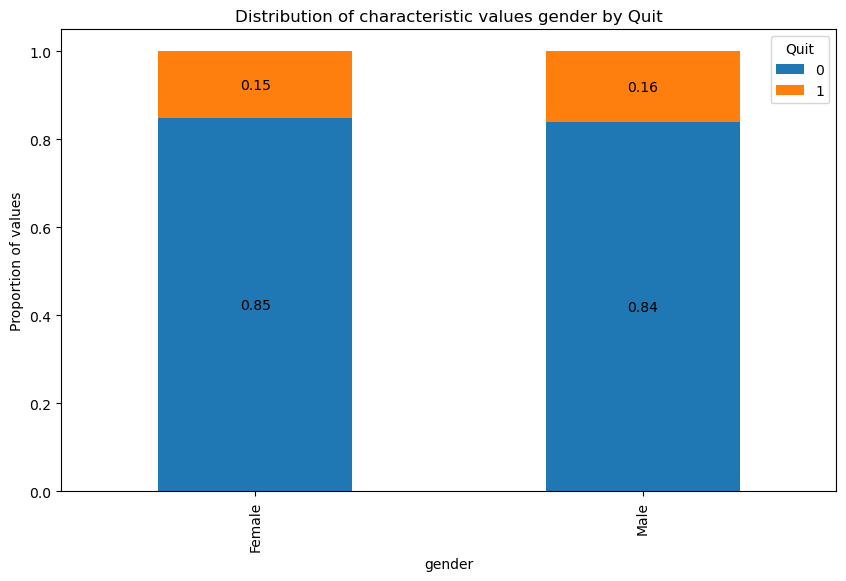

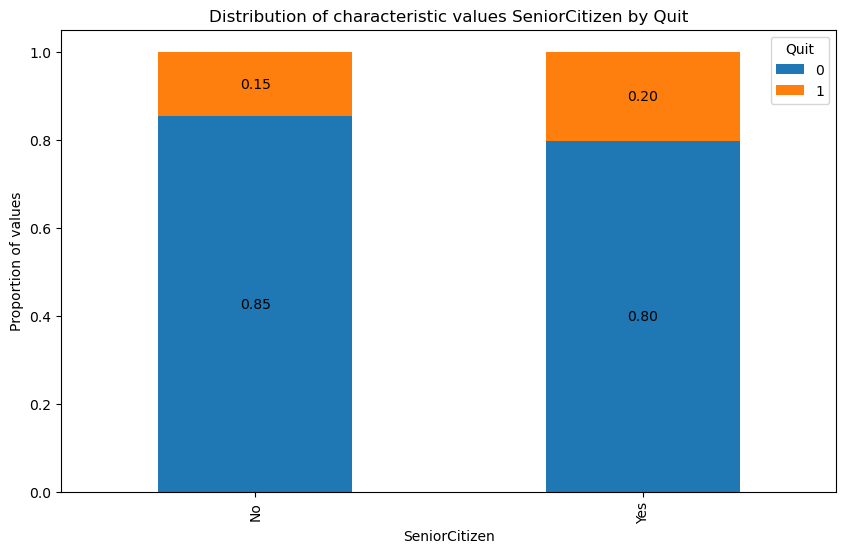

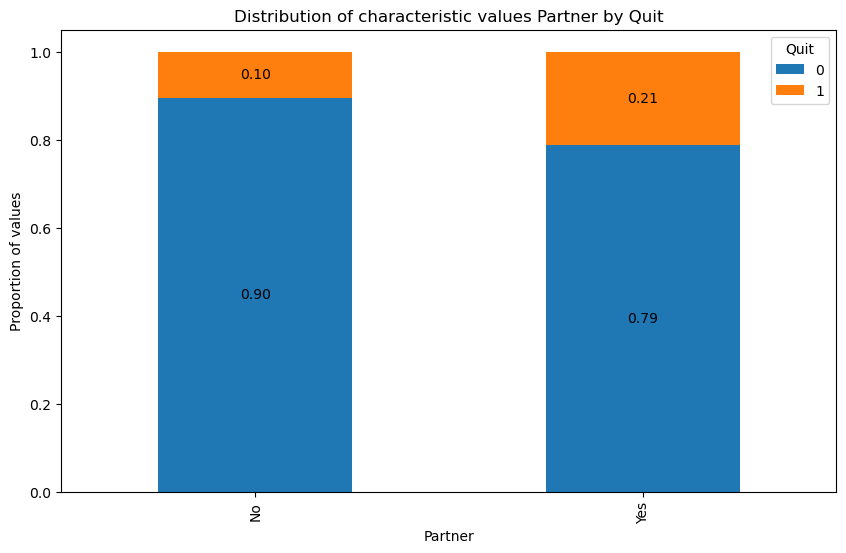

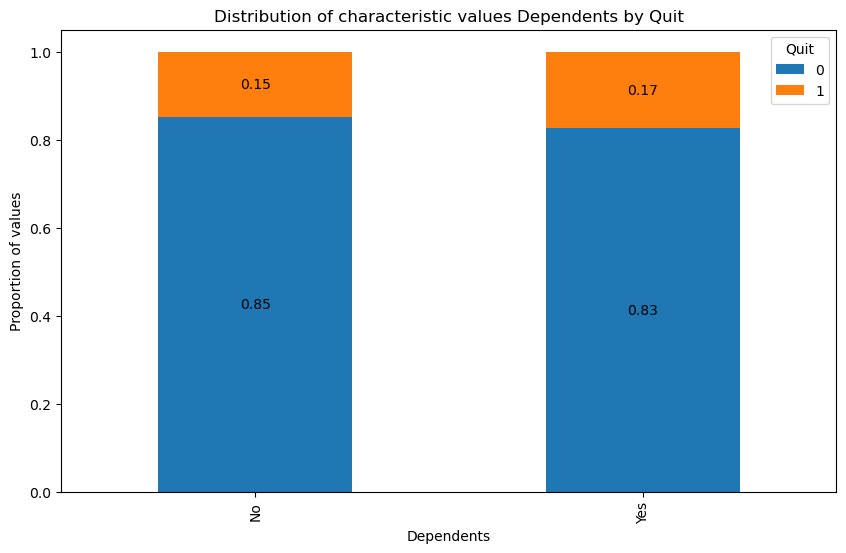

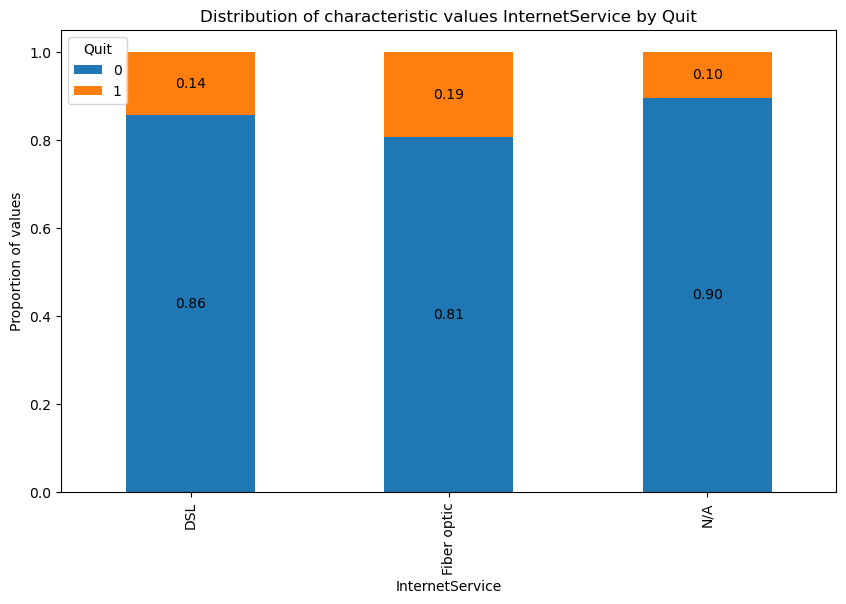

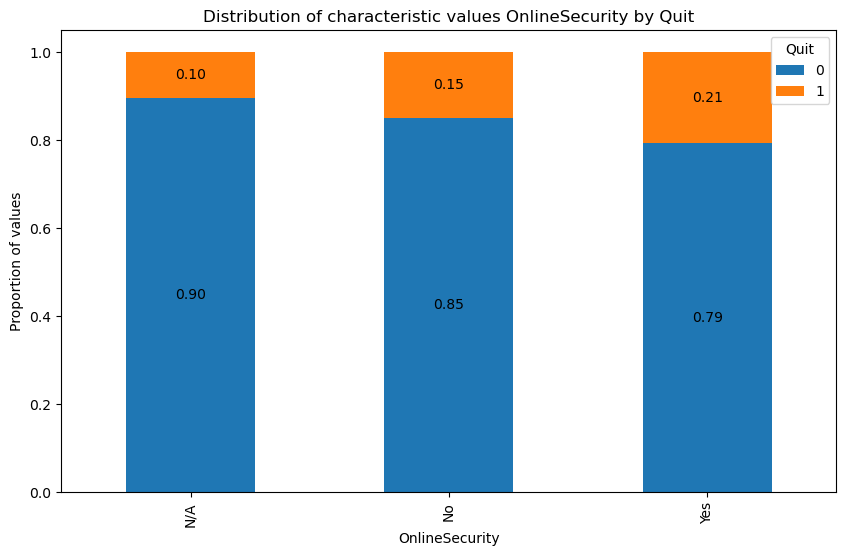

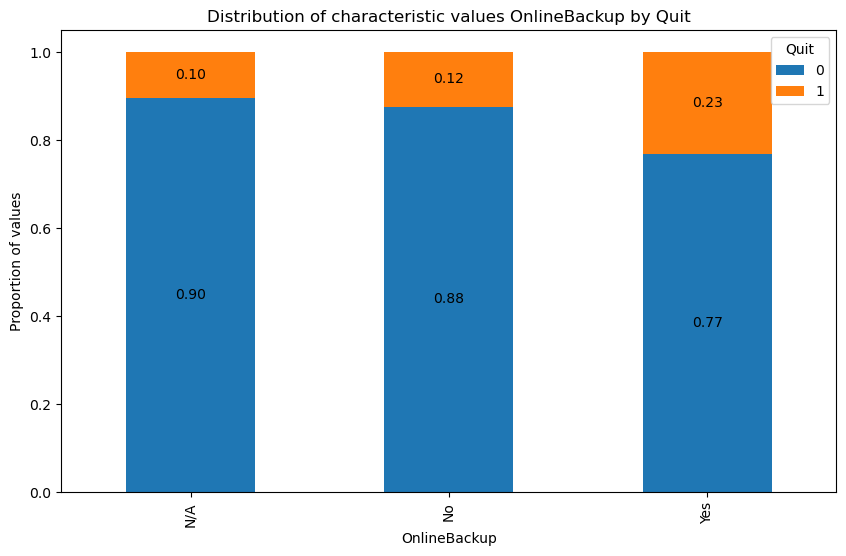

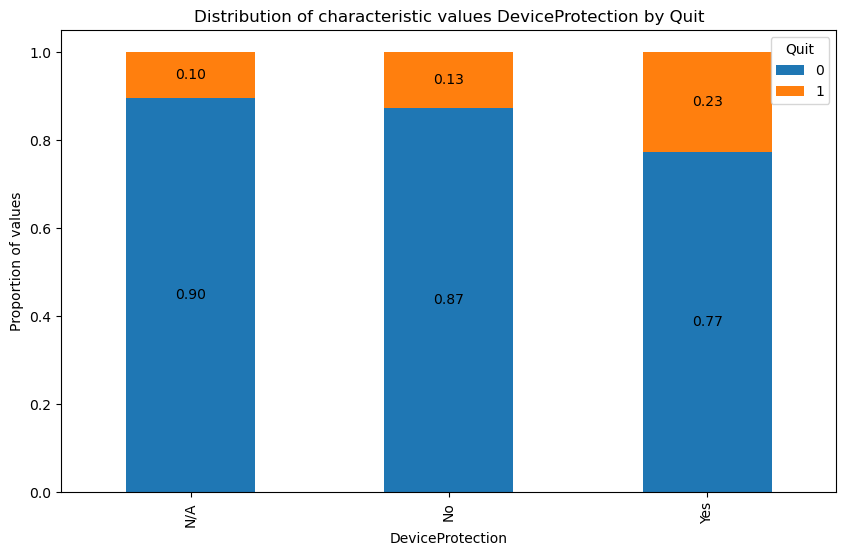

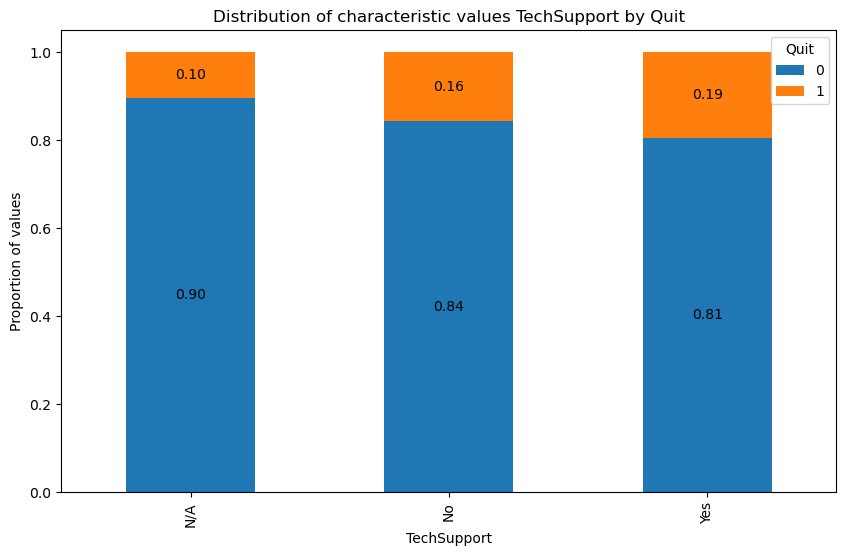

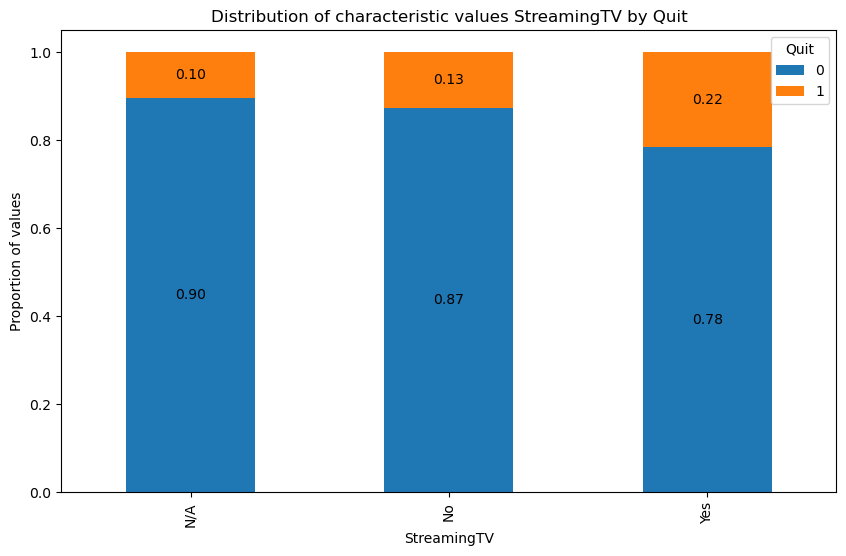

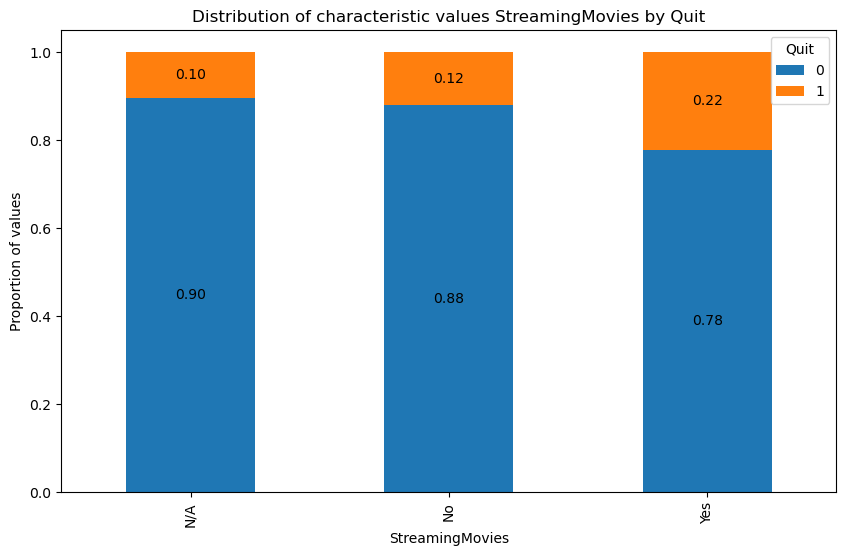

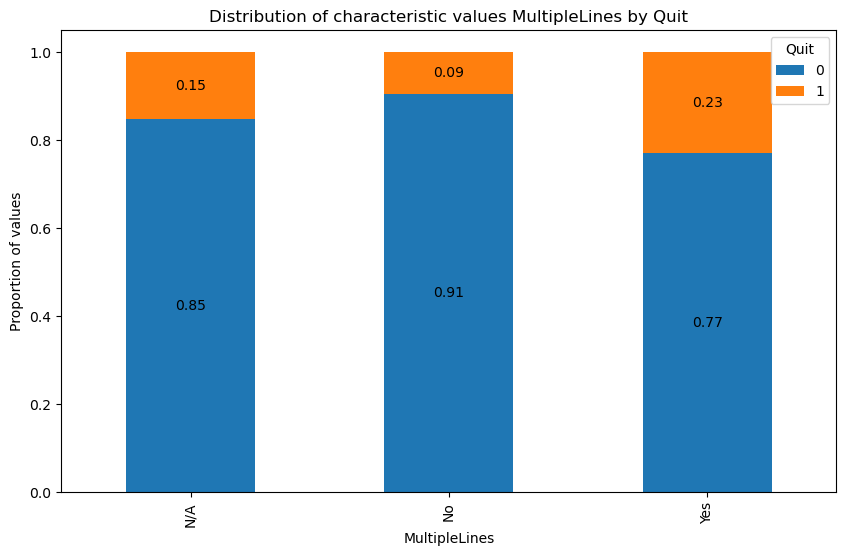

In [60]:
for col in categorical_features:
    plot_categorical_distribution(data,col)

- After analysis, you can notice that the greater the number of services, the greater the proportion of departed customers, with the exception of loyal customers.
- The biggest difference between the shares of clients with and without a partner; clients with partners are twice as likely to leave.
- The smallest difference between the shares of clients depends on the gender of the clients, followed by the presence of children. Perhaps these signs will not bring much weight to the future model.

### Correlation analysis of a merged dataframe

In [61]:
# create a list with the names of continuous features
interval_cols = numerical_features

# count correlations on the training set
phik_overview = data.phik_matrix(interval_cols=interval_cols)
print(phik_overview.shape)

(20, 20)


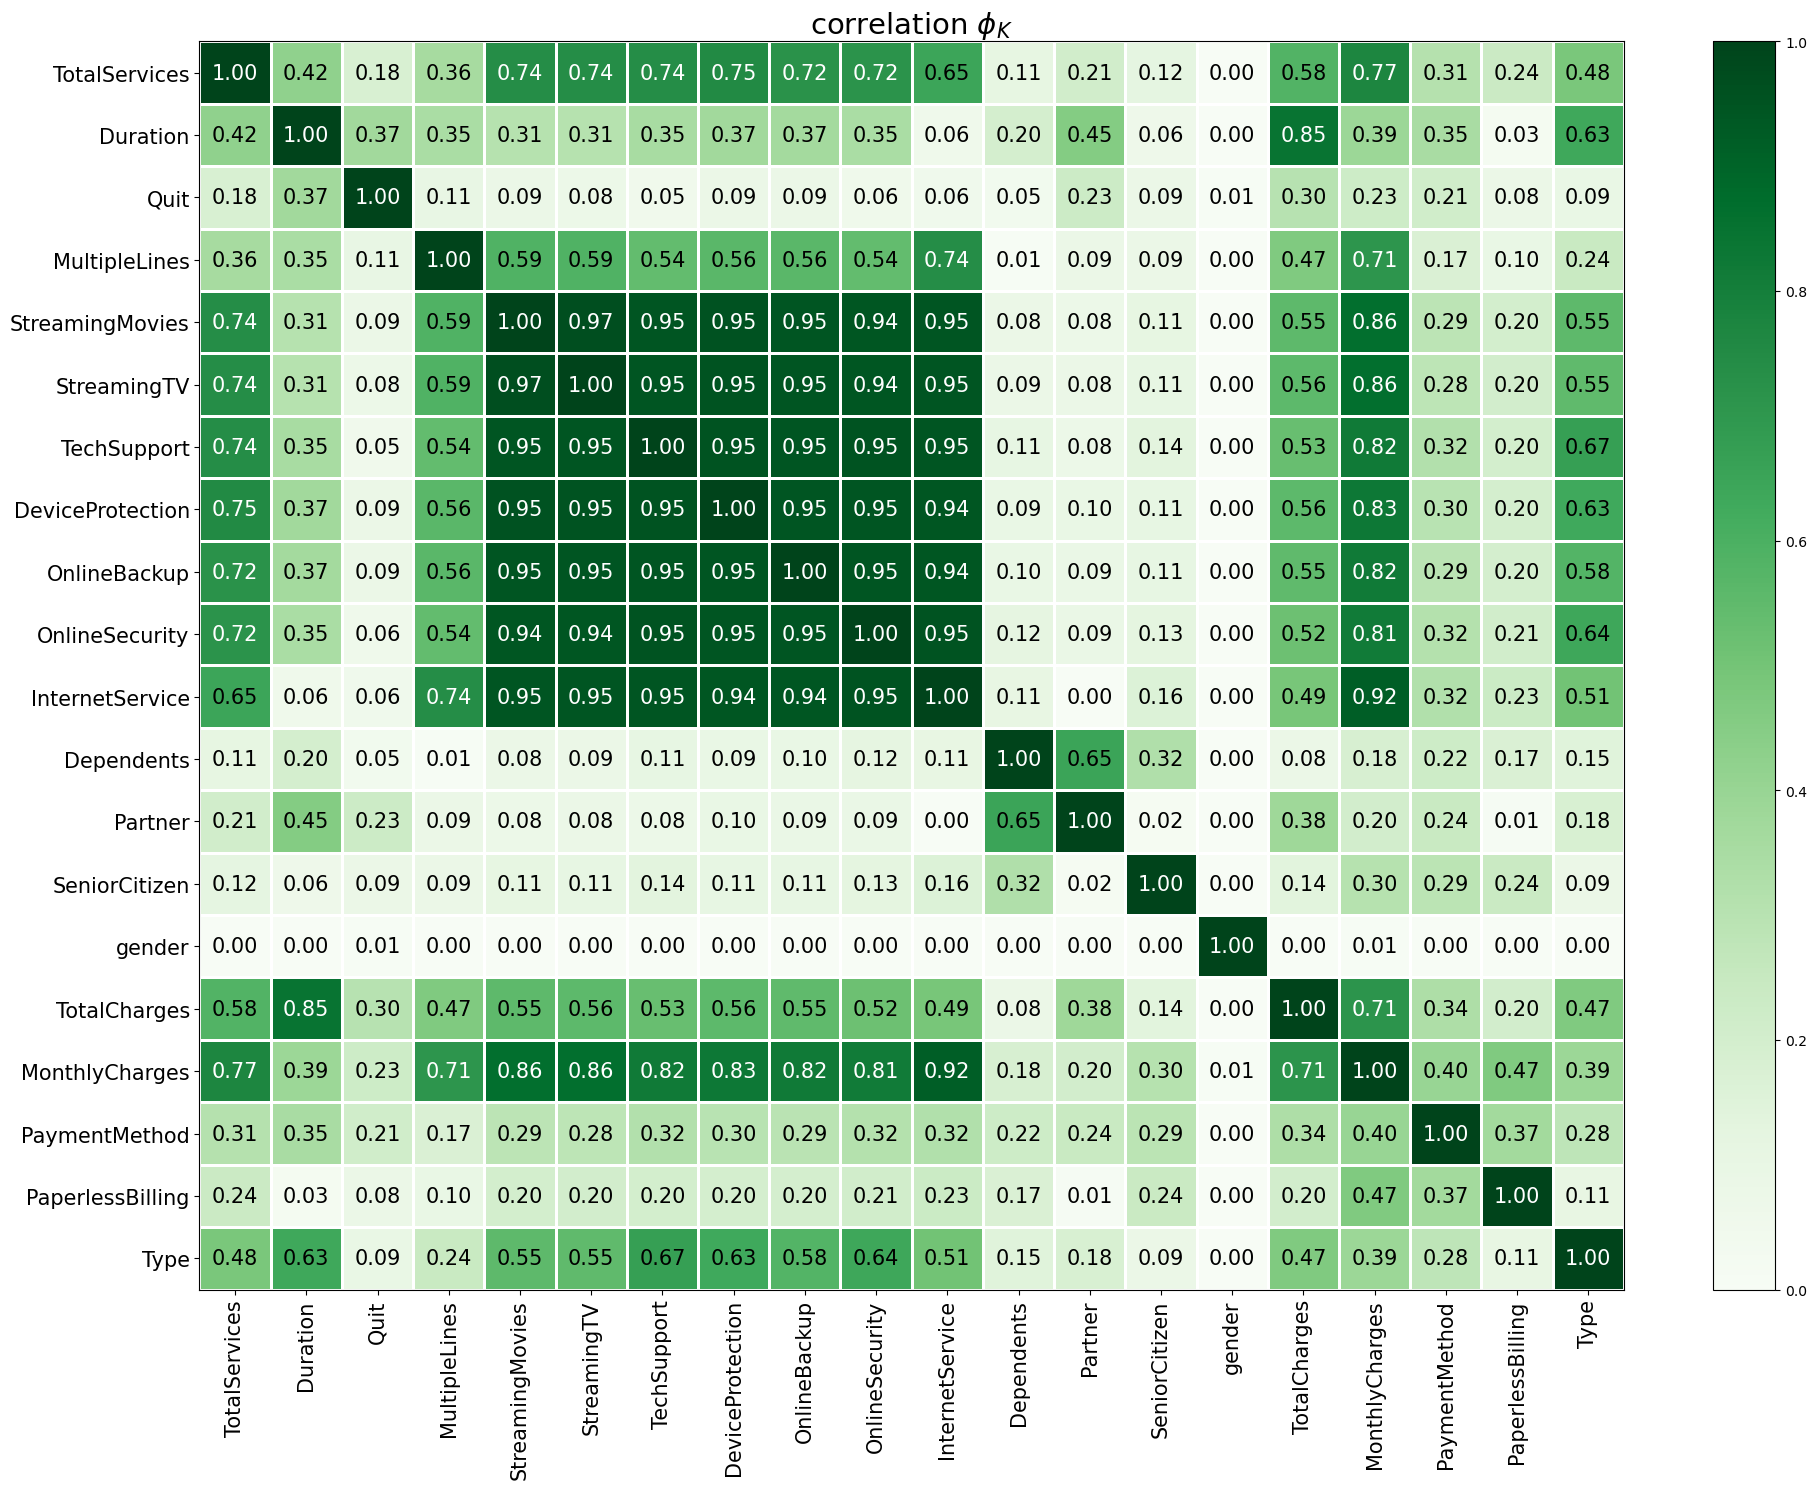

In [62]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

- All columns from the Internet table are highly correlated with each other. Since a new attribute was added, it makes sense to remove these values.
- It also makes sense to remove the gender column, as it has minimal impact on the target.
- It is also worth removing the InternetService column, as it is highly correlated with MothlyCharges and does not particularly affect the target trait.

**Conclusion:** 
- Preprocessing of the combined dataframe data was carried out. 
   - Filled in gaps
   - Changed data type for several columns
   - Target feature has been added
   - New signs have been added

- Correlation and exploratory analyzes of the combined dataframe were carried out. Columns with a temporary data type were removed. During the analysis, some patterns were found in the behavior of clients who left. After the correlation analysis, it was decided to get rid of a number of other features. It is also worth noting that there is a strong imbalance of the target feature.

## Data preparation

Plan for this step:
- Let's prepare data for the model:
  - remove unnecessary signs
  - divide into training and training samples in a ratio of 3:1
  - separate the target feature
- Let's draw conclusions

In [63]:
columns_to_delete=['TotalCharges','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','gender','InternetService']
try: 
    data.drop(columns=columns_to_delete, inplace=True)
    numerical_features.remove('TotalCharges')
    categorical_features = [col for col in categorical_features if col not in columns_to_delete]
except: 
    pass
data[categorical_features] = data[categorical_features].astype('category')

In [64]:
discription(data)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7043 non-null   category
 1   PaperlessBilling  7043 non-null   category
 2   PaymentMethod     7043 non-null   category
 3   MonthlyCharges    7043 non-null   float64 
 4   SeniorCitizen     7043 non-null   category
 5   Partner           7043 non-null   category
 6   Dependents        7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   Quit              7043 non-null   int32   
 9   Duration          7043 non-null   int64   
 10  TotalServices     7043 non-null   int64   
dtypes: category(7), float64(1), int32(1), int64(2)
memory usage: 554.7+ KB


,MonthlyCharges,Quit,Duration,TotalServices
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,0.156325,898.555729,2.037910
std,30.090047,0.363189,683.130510,1.847682
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,0.000000,276.000000,0.000000
50%,70.350000,0.000000,761.000000,2.000000
75%,89.850000,0.000000,1461.000000,3.000000
max,118.750000,1.000000,2314.000000,6.000000


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,MultipleLines,Quit,Duration,TotalServices
customerID,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,No,Yes,No,N/A,0,31,1
5575-GNVDE,One year,No,Mailed check,56.95,No,No,No,No,0,1036,2
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,No,No,No,No,0,123,2
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,No,No,No,N/A,0,1371,3
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,No,No,No,No,0,153,0


In [65]:
features = data.drop(['Quit'], axis=1)
target = data['Quit']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)
print('Training set: ', X_train.shape, y_train.shape)
print('Testing set: ', X_test.shape, y_test.shape)

Training set:  (5282, 10) (5282,)
Testing set:  (1761, 10) (1761,)


**Conclusion:** Unnecessary features were removed. We also prepared for training the models by selecting training and test samples. The final sample included 11 features.

## Training machine learning models

Plan for this step:
- We will train three models of different types with the selection of hyperparameters.
  - Logistic Regression Model
  - Random Forest Model
  - CatBoostClassifier Model
- For each model, we will create a pipeline with feature processing.
- Let's analyze the importance of the signs.
- Let's draw conclusions

### Logistic Regression Model

For the logistic regression model we will use OneHotEncoder and StandardScaler.

In [66]:
ohe_features_lr = categorical_features
print(ohe_features_lr)
num_features_lr = numerical_features
print(num_features_lr)

['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']
['MonthlyCharges', 'Duration', 'TotalServices']


In [67]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

In [68]:
col_transformer_lr = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_lr
    ),
    (
        StandardScaler(),
        num_features_lr
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

X_train_transformed = col_transformer_lr.fit_transform(X_train_lr)

X_train_lr = pd.DataFrame(
    X_train_transformed,
    columns=col_transformer_lr.get_feature_names_out()
)

X_train_lr.head()

,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,MultipleLines_No,MultipleLines_Yes,MonthlyCharges,Duration,TotalServices
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.377113,-1.100488,-0.567815
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.095840,1.400352,1.596890
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.686864,1.178740,2.138066
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.038249,0.014910,-0.026639
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.516366,-0.429782,-1.108991


In [69]:
X_test_transformed = col_transformer_lr.transform(X_test_lr)

X_test_lr = pd.DataFrame(
    X_test_transformed,
    columns=col_transformer_lr.get_feature_names_out()
)

X_test_lr.head()

,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,MultipleLines_No,MultipleLines_Yes,MonthlyCharges,Duration,TotalServices
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,-0.510507,-0.566271,-0.567815
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,-0.633741,-0.965466,-1.108991
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-1.514700,-1.054992,-1.108991
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.143967,-1.100488,-1.108991
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,-0.109163,0.864667,0.514537


In [70]:
model_lr = LogisticRegression(random_state = RANDOM_STATE)

param_grid_lr = {
               'penalty' : ['l1', 'l2'],
               'solver' :['saga','liblinear'],
               'C' : [0.01, 0.1, 1],
               'class_weight' : [None, 'balanced']
              }


gs_lr = GridSearchCV(
    model_lr,
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
start_time = time.time()
gs_lr.fit(X_train_lr, y_train)
training_time_lr = time.time() - start_time
best_params_lr = gs_lr.best_params_
print('Logistic regression model results:')
print(f'Model metric: {gs_lr.best_score_}')
print(f'Training time: {round(training_time_lr,2)}c')
print(f'Best parameters: {gs_lr.best_params_}')

Logistic regression model results:
Model metric: 0.7403229743808144
Training time: 1.59c
Best parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


### Random Forest Model

For the logistic regression model we will use OrdinalEncoder.

In [71]:
ord_features_rf = categorical_features
print(ord_features_rf)

['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']


In [72]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [73]:
col_transformer_rf = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='error'),
        ord_features_rf
    ),
    
    remainder='passthrough',
    verbose_feature_names_out=False
)

X_train_transformed = col_transformer_rf.fit_transform(X_train_rf)

X_train_rf = pd.DataFrame(
    X_train_transformed,
    columns=X_train.columns
)

X_train_rf.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,MultipleLines,Duration,TotalServices
0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,76.35,153.0,1.0
1,2.0,1.0,3.0,0.0,1.0,0.0,0.0,62.15,1857.0,5.0
2,2.0,1.0,0.0,1.0,1.0,0.0,1.0,85.65,1706.0,6.0
3,0.0,1.0,2.0,1.0,0.0,0.0,2.0,96.20,913.0,2.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,19.50,610.0,0.0


In [74]:
X_test_transformed = col_transformer_rf.transform(X_test_rf)

X_test_rf = pd.DataFrame(
    X_test_transformed,
    columns=X_test.columns
)

X_test_rf.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,MultipleLines,Duration,TotalServices
0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,49.70,517.0,1.0
1,0.0,0.0,2.0,1.0,1.0,1.0,1.0,46.00,245.0,0.0
2,0.0,0.0,3.0,0.0,0.0,1.0,1.0,19.55,184.0,0.0
3,0.0,1.0,2.0,1.0,1.0,0.0,1.0,69.35,153.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,61.75,1492.0,3.0


In [75]:
model_rf = RandomForestClassifier(random_state = RANDOM_STATE)

param_grid_rf = {'max_depth': range(1, 20, 1),
                 'min_samples_leaf': range(1, 11, 1),
                 'n_estimators': [10, 50],
                 'class_weight' : [None, 'balanced']
                }


gs_rf = GridSearchCV(
    model_rf,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
start_time = time.time()
gs_rf.fit(X_train_rf, y_train)
training_time_rf = time.time() - start_time
best_params_rf = gs_rf.best_params_
print('Random forest model results:')
print(f'Model metric: {gs_rf.best_score_}')
print(f'Training time: {round(training_time_rf,2)}c')
print(f'Best parameters: {gs_rf.best_params_}')

Random forest model results:
Model metric: 0.8234937470891037
Training time: 209.48c
Best parameters: {'class_weight': None, 'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 50}


### CatBoostClassifier

In [76]:
features_cat = categorical_features
print(features_cat)

['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']


In [77]:
model_cat = CatBoostClassifier(cat_features=features_cat, random_state=RANDOM_STATE, verbose=0)
params = {
    'learning_rate': [0.1, 0.5, 1],
    'iterations': [100, 250],
    'depth':range(1,4),
    'l2_leaf_reg':[1,3,5]
}


gs_cat = GridSearchCV(model_cat, params, scoring='roc_auc')
start_time = time.time()
gs_cat.fit(X_train, y_train)
training_time_cat = time.time() - start_time
print('CatBoostClassifier model results:')
print('Model metric:', gs_cat.best_score_)
print(f'Training time: {round(training_time_cat,2)}c')
print('Best parameters:', gs_cat.best_params_)

CatBoostClassifier model results:
Model metric: 0.9274184577560775
Training time: 727.34c
Best parameters: {'depth': 2, 'iterations': 250, 'l2_leaf_reg': 1, 'learning_rate': 1}


**Conclusion:** 3 different models were trained: Logistic Regression Model, Random Forest Model,
CatBoostClassifier model. For each model, the best hyperparameters were selected, as well as training time.

## Choosing the best model

Plan for this step:
 - Let's choose the best model.
 - For the best model, we will analyze the features.
 - Let's test the best model on a test sample.
 - Let's plot the ROC curve for the best model.
 - For a clearer interpretation, let’s calculate the accuracy metric.
 - Let's draw conclusions.

In [78]:
results_df = pd.DataFrame({
    'Model': ['Logistic Regression Model', 'Random Forest Model', 'CatBoostClassifier Model'],
    'Model metric': [gs_lr.best_score_, gs_rf.best_score_, gs_cat.best_score_ ],
    'Training time (s)': [round(training_time_lr,2), round(training_time_rf,2), round(training_time_cat ,2)]
})
results_df.set_index('Model', inplace=True)
# Display a table with results
results_df

,Model metric,Training time (s)
Model,,
Logistic Regression Model,0.740323,1.59
Random Forest Model,0.823494,209.48
CatBoostClassifier Model,0.927418,727.34


The only model that was able to pass the metric threshold (ROC-AUC >= 0.85) is the CatBoostClassifier model.

Let's check this model on a test sample.

In [79]:
# Check on test sample
best_model = gs_cat.best_estimator_
#best_model.fit(X_train, y_train)
y_test_proba = best_model.predict_proba(X_test)[:, 1]
best_roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"Best quality on the test set (ROC-AUC): {best_roc_auc}")

Best quality on the test set (ROC-AUC): 0.9346499606415677


The metric threshold has been passed.

Let's analyze the importance of features for this model.

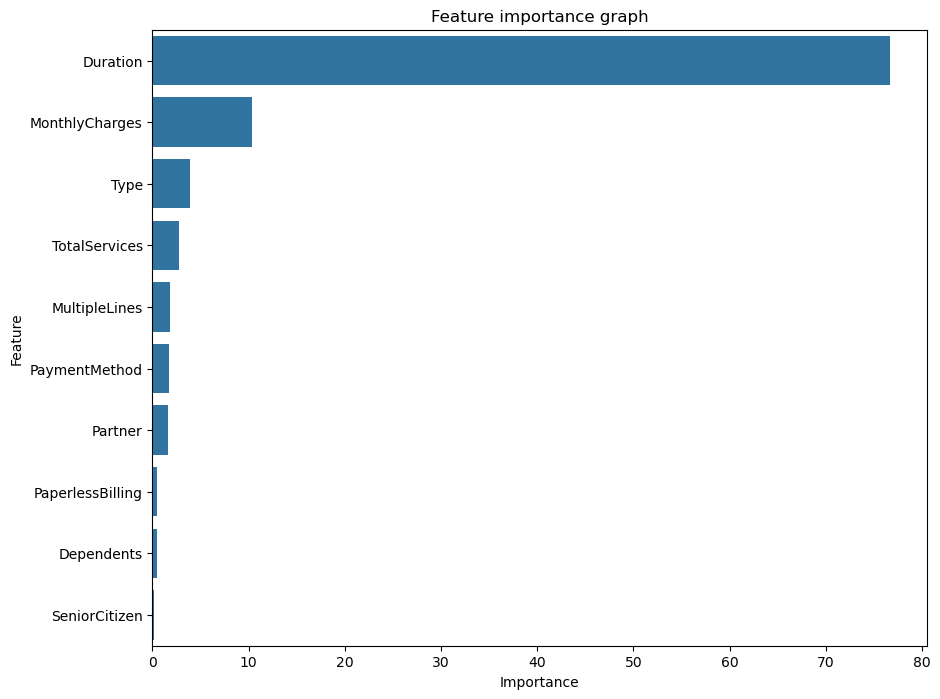

In [80]:
feature_importances = best_model.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature importance graph')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

All the traits we created performed well, especially the *Duration*. The attributes *PaperLessBilling*, *SeniorCitizen*, and *Dependents* have the least impact on the model.

Let's plot the ROC curve for the best model

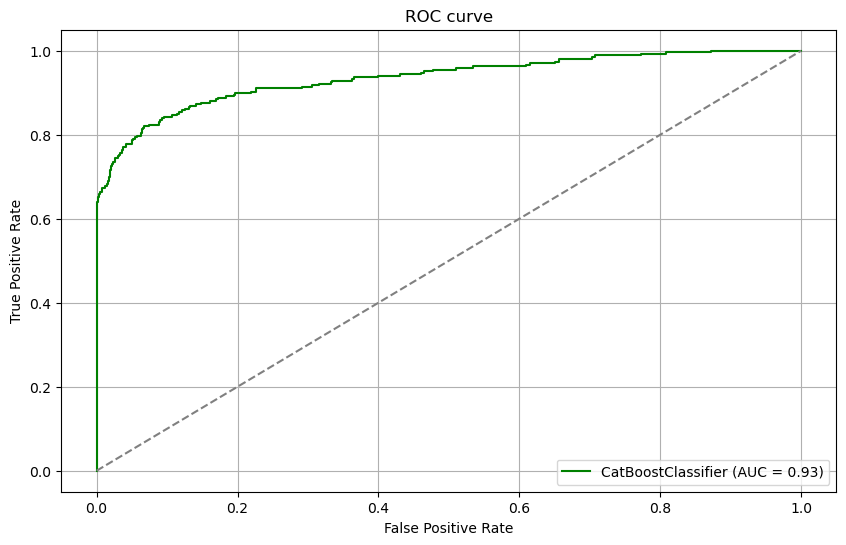

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'CatBoostClassifier (AUC = {best_roc_auc:.2f})', color='green')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [82]:
# Find the threshold that maximizes the sum of sensitivity and specificity
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.17017143128762

Using the ROC curve, a threshold was selected where the sum of sensitivity and specificity is maximum. The threshold is 0.17.

For a clearer interpretation, let’s calculate the accuracy metric

In [83]:
# Getting predictions on a test sample
y_pred = best_model.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the best model: {round(accuracy,3)*100}%')

Accuracy of the best model: 94.1%


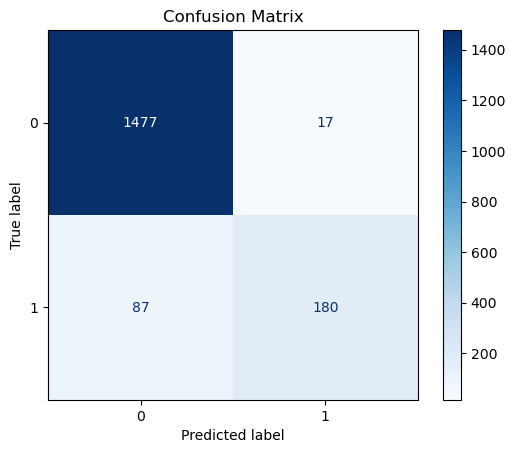

In [84]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Explanation of error matrix elements:
 - True Positives (TP): Correct predictions of positive cases (in this case 180).
 - True Negatives (TN): Correct predictions of negative cases (in this case 1477).
 - False Positives (FP): Incorrectly predicting positive cases when they are actually negative (in this case 17).
 - False Negatives (FN): Incorrectly predicting negative cases when they are actually positive (in this case 87).

Precision is the percentage of correct positive predictions among all predicted positive cases.

Recall is the percentage of correct positive predictions among all actual positive cases.

In [85]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.9137055837563451
Recall: 0.6741573033707865


High overall accuracy: The model correctly classifies 94.1% of all cases, indicating high overall accuracy.

High Precision: The model has a high accuracy in predicting positive cases (91.4%), which means that most of the predicted positive cases are actually positive.

Low sensitivity (Recall): The model misses a significant number of positive cases (67.4%). This indicates that the model does not detect all positive cases.

**Conclusion:** The best model was selected - CatBoostClassifier. For this model, the metric ROC-AUC = 0.94 was calculated. And also the accuracy metric. Accuracy of the best model: 94.1%. All the traits we created performed well, especially the Duration trait.

## General conclusion and recommendations to the customer

As part of the project, a customer outflow forecast was implemented for the telecom operator TeleDom. The goal of the project was to create a model that predicts the likelihood of a subscriber terminating a contract. To achieve this goal, the following work steps were completed:

1. **Data loading**: The provided data about clients, tariffs and services was downloaded and initially examined.
2. **Exploratory analysis and data preprocessing**: Data analysis was carried out to identify important features. Data preprocessing has been completed, including processing of gaps, .
3. **Creation of new features**: New features were generated to improve the quality of the model.
4. **Correlation analysis**: An analysis of the correlation between characteristics was carried out to identify relationships and eliminate multicollinearity.
5. **Data preparation**: The data is divided into training and test sets. Scaling and coding of data was carried out.
6. **Training machine learning models**: Several models were trained, including logistic regression, random forest and gradient boosting (CatBoost). The selection of hyperparameters to improve the models was carried out.
7. **Selecting the best model**: Models are compared based on quality metrics. The best model is selected based on ROC-AUC and accuracy.

**Results:**

- **Best Model**: The gradient boosting model (CatBoost) showed the best results with high accuracy and AUC-ROC.
- **Metrics**:
  - **ROC-AUC**: 0.9346
  - **Accuracy**: 94.1%

**Recommendations to the customer:**

1. **Using the model in business**: It is recommended to implement the developed model in business processes to predict customer churn. The model will help to timely identify clients who are planning to terminate the contract and apply deterrent measures to them.
   
2. **Monitoring and updating the model**: It is necessary to regularly update the model with new data to maintain its relevance and accuracy. It is also recommended to monitor the quality metrics of the model and, if necessary, retrain it.

3. **Expanding the data set**: To increase the accuracy of the model, you can add new features, for example, data on customer interactions with technical support or the results of satisfaction surveys.

4. **Personalized offers**: Based on model predictions, develop personalized offers for customers with a high risk of churn, such as discounts, bonuses or improved tariff conditions.

In general, the work performed showed that using machine learning can significantly increase the efficiency of working with customers and reduce the level of churn, which will have a positive impact on the telecom operator’s business.